In [1]:
!pip install numpy==1.26.4

In [2]:
!pip install scikit-surprise

In [3]:
!pip install tensorflow keras pandas scikit-learn matplotlib seaborn

# **Import Library**

In [4]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, Model # noqa: F811
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.model_selection import train_test_split as sklearn_train_test_split # Untuk NCF


# Scikit-surprise untuk Model Collaborative Filtering
from surprise import Reader, Dataset, SVD # noqa: F811
from surprise.model_selection import train_test_split as surprise_train_test_split
from surprise import accuracy # noqa: F811

# Scikit-learn untuk Content-Based dan Utilitas
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
# from surprise import Reader, Dataset, SVD, accuracy # Duplikat, sudah diimpor
# from surprise.model_selection import train_test_split # Duplikat
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# **1. Data Loading & Overview**

Tahap ini melibatkan mounting Google Drive (jika data ada di sana) dan memuat dataset film, rating, dan tag.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Bagian ini digunakan untuk menghubungkan Google Drive ke Google Colab. Dengan ini, file dataset yang disimpan di Google Drive dapat diakses langsung dari Colab.

3 csv dimuat dari file .csv di path content/mydrive dari drive. Menggunakan pandas:

In [6]:
print("\n--- 2. Data Loading ---")
ratings= pd.read_csv('/content/drive/MyDrive/Machine Learning/Movie/rating.csv', nrows=120000)
movies= pd.read_csv('/content/drive/MyDrive/Machine Learning/Movie/movie.csv', nrows=20000)
tags= pd.read_csv('/content/drive/MyDrive/Machine Learning/Movie/tag.csv', nrows=20000)


--- 2. Data Loading ---


Baris ini membaca file CSV yang berisi data rating, film, dan tag menggunakan pandas. Parameter nrows digunakan untuk membatasi jumlah baris data yang diambil, sehingga hanya sebagian dataset yang dimuat untuk efisiensi.



In [7]:
# Membuat copy untuk diproses agar data asli tetap aman
df_ratings = ratings.copy()
df_movies = movies.copy()
df_tags = tags.copy()

Salinan data dibuat dengan menggunakan copy(). Tujuannya adalah menjaga data asli tetap utuh sehingga jika terjadi modifikasi, kita masih memiliki data awal.

## **1. Informasi Dataset**

In [8]:
print("\n--- 3. Melakukan Analisis Data Eksploratif (EDA) ---")

# Tampilan awal data
print("\nContoh Data Movies:")
print(df_movies.head(3))
print("\nContoh Data Ratings:")
print(df_ratings.head(3))
print("\nContoh Data Tags:")
print(df_tags.head(3))


--- 3. Melakukan Analisis Data Eksploratif (EDA) ---

Contoh Data Movies:
   movieId                    title  \
0        1         Toy Story (1995)   
1        2           Jumanji (1995)   
2        3  Grumpier Old Men (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  

Contoh Data Ratings:
   userId  movieId  rating            timestamp
0       1        2     3.5  2005-04-02 23:53:47
1       1       29     3.5  2005-04-02 23:31:16
2       1       32     3.5  2005-04-02 23:33:39

Contoh Data Tags:
   userId  movieId          tag            timestamp
0      18     4141  Mark Waters  2009-04-24 18:19:40
1      65      208    dark hero  2013-05-10 01:41:18
2      65      353    dark hero  2013-05-10 01:41:19


Kode ini menampilkan beberapa baris awal dari masing-masing dataset menggunakan head() untuk memahami struktur data. Fungsi info() memberikan informasi penting tentang dataset seperti jumlah kolom, jenis data di setiap kolom, dan jumlah nilai non-null.

In [9]:
# Informasi umum dataset
print("\nInformasi Detail Movies:")
df_movies.info()
print("\nInformasi Detail Ratings:")
df_ratings.info()
print("\nInformasi Detail Tags:")
df_tags.info()


Informasi Detail Movies:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  20000 non-null  int64 
 1   title    20000 non-null  object
 2   genres   20000 non-null  object
dtypes: int64(1), object(2)
memory usage: 468.9+ KB

Informasi Detail Ratings:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     120000 non-null  int64  
 1   movieId    120000 non-null  int64  
 2   rating     120000 non-null  float64
 3   timestamp  120000 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 3.7+ MB

Informasi Detail Tags:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------  

Kode inii digunakan untuk menampilkan informasi umum tentang dataset:

- df_movies.info(): Menampilkan jumlah baris dan kolom, tipe data, jumlah nilai non-null, dan penggunaan memori untuk dataset film.

- df_ratings.info(): Memberikan informasi struktur dataset rating, termasuk kolom seperti userId, movieId, dan rating.

- df_tags.info(): Menjelaskan struktur dataset tag, termasuk jumlah tag yang tersedia dan tipe data masing-masing kolom.

Ini membantu memverifikasi apakah data lengkap, mengenali tipe data, dan memastikan dataset siap untuk analisis lebih lanjut.

# **2. DATA UNDERSTANDING (EXPLORATORY DATA ANALYSIS - EDA)**

Kode ini menampilkan beberapa baris awal dari masing-masing dataset menggunakan head() untuk memahami struktur data. Fungsi info() memberikan informasi penting tentang dataset seperti jumlah kolom, jenis data di setiap kolom, dan jumlah nilai non-null.

## **1. Statistik Dasar Data**

In [10]:
# Statistik dasar
users_count = df_ratings['userId'].nunique()
movies_rated_count = df_ratings['movieId'].nunique()
movies_total_count = df_movies['movieId'].nunique()
ratings_count = len(df_ratings)

print(f"\nJumlah pengguna unik: {users_count}")
print(f"Jumlah film yang pernah dirating: {movies_rated_count}")
print(f"Total film dalam dataset movies: {movies_total_count}")
print(f"Jumlah total entri rating: {ratings_count}")



Jumlah pengguna unik: 806
Jumlah film yang pernah dirating: 9183
Total film dalam dataset movies: 20000
Jumlah total entri rating: 120000


Bagian ini menghitung jumlah pengguna unik, jumlah film yang dirating, total film yang ada di dataset, dan total entri rating menggunakan fungsi nunique() dan len(). Statistik ini membantu memahami skala dataset.

  - Jumlah pengguna unik dalam data rating: 806 pengguna.
  - Jumlah film yang pernah dirating dalam data rating: 9183 film.
  - Total film dalam dataset movies: 20000 film.
  - Jumlah total entri rating: 120000 entri.

## **2. Visualisasi: Distribusi Rating Pengguna**


Membuat visualisasi distribusi rating...


<ipython-input-11-b4636d8d8641>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df_ratings, palette='crest_r') # Variasi palet warna


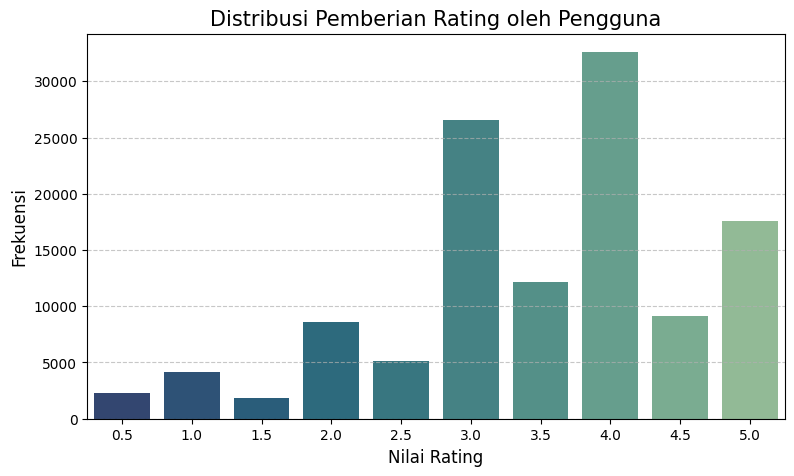

In [11]:
# Visualisasi: Distribusi Rating Pengguna
print("\nMembuat visualisasi distribusi rating...")
plt.figure(figsize=(9, 5))
sns.countplot(x='rating', data=df_ratings, palette='crest_r') # Variasi palet warna
plt.title('Distribusi Pemberian Rating oleh Pengguna', fontsize=15)
plt.xlabel('Nilai Rating', fontsize=12)
plt.ylabel('Frekuensi', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Visualisasi ini menggunakan seaborn untuk membuat diagram batang yang menggambarkan distribusi nilai rating dalam dataset. Parameter palette memberikan warna yang menarik, dan grid() menambahkan garis bantu untuk membaca grafik dengan lebih mudah.

  - Visualisasi menggunakan `countplot` menunjukkan bahwa rating **5.0** adalah yang paling sering diberikan, diikuti oleh **4.5**,**4.0** **3.0** dan **3.5**. Rating rendah seperti **0.5** atau **1.5** lebih jarang diberikan. Ini mengindikasikan kecenderungan pengguna untuk memberikan rating yang positif atau netral.
  - *Insight*: Distribusi rating ini penting untuk model Collaborative Filtering, karena model akan belajar dari pola rating ini.

## **3. Visualisasi**: Jumlah Film per Genre

Visualisasi ini digunakan untuk menampilkan jumlah film berdasarkan genre, membantu memahami dominasi genre tertentu dalam dataset. Prosesnya melibatkan pemisahan genre, penghitungan frekuensi, dan memplot data menggunakan diagram batang horizontal.


Membuat visualisasi jumlah film per genre...


<ipython-input-12-7fa83e7d728e>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=valid_genre_counts.index, x=valid_genre_counts.values, palette='magma_r') # Variasi palet


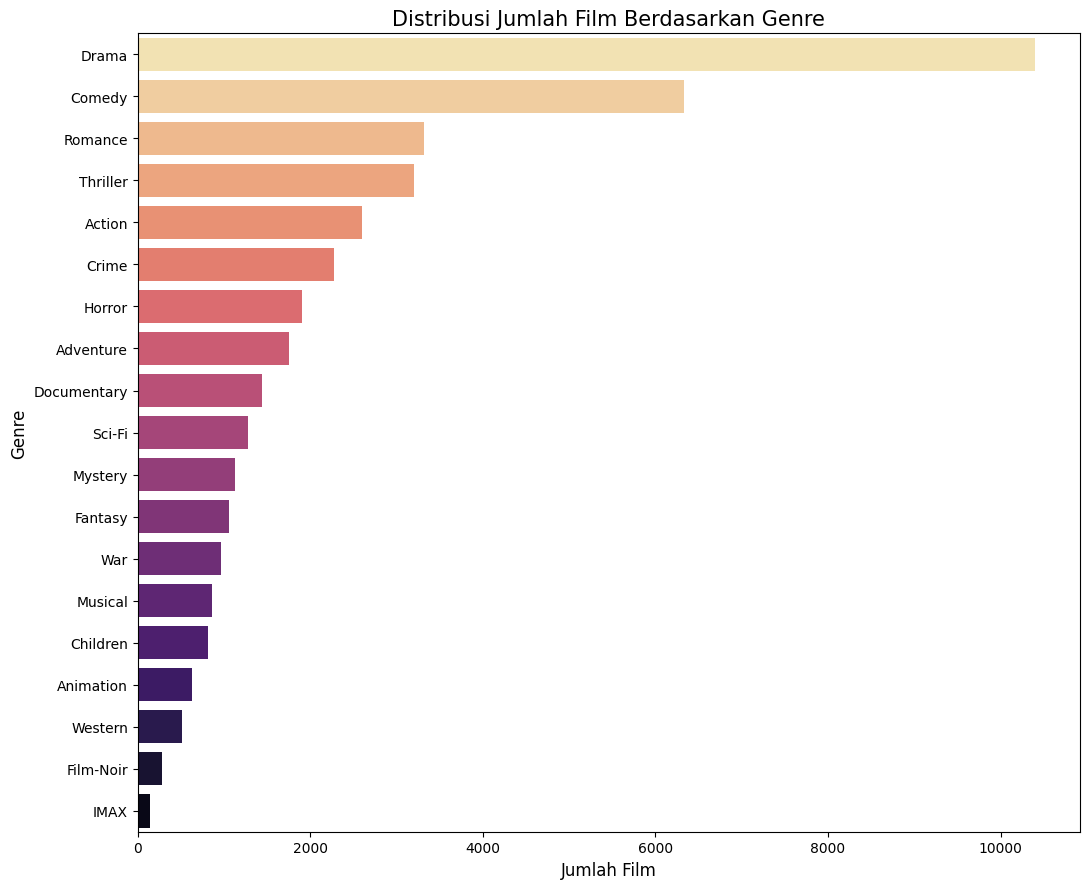

In [12]:
# Visualisasi: Jumlah Film per Genre
print("\nMembuat visualisasi jumlah film per genre...")
movies_for_eda = df_movies.copy()
# Mengatasi nilai NaN di genre dan memastikan format string
movies_for_eda['genres'] = movies_for_eda['genres'].fillna('').astype(str)
# Memecah genre dan menghitung frekuensinya
all_movie_genres = movies_for_eda['genres'].str.split('|').explode()
# Filter genre yang tidak valid seperti '(no genres listed)'
valid_genre_counts = all_movie_genres[all_movie_genres != '(no genres listed)'].value_counts()

if not valid_genre_counts.empty:
    plt.figure(figsize=(11, 9)) # Ukuran disesuaikan
    sns.barplot(y=valid_genre_counts.index, x=valid_genre_counts.values, palette='magma_r') # Variasi palet
    plt.title('Distribusi Jumlah Film Berdasarkan Genre', fontsize=15)
    plt.xlabel('Jumlah Film', fontsize=12)
    plt.ylabel('Genre', fontsize=12)
    plt.tight_layout() # Memastikan label tidak terpotong
    plt.show()
else:
    print("Tidak ditemukan data genre yang valid untuk divisualisasikan.")

  - Visualisasi menggunakan `barplot` setelah memecah dan menghitung genre menunjukkan bahwa genre **Drama** dan **Comedy** adalah yang paling dominan dalam dataset film. Genre seperti **Film-Noir** atau **IMAX** lebih jarang muncul.
  - *Insight*: Dominasi genre tertentu dapat mempengaruhi rekomendasi berbasis konten. Model mungkin lebih cenderung merekomendasikan film dari genre populer jika tidak ada penanganan khusus.

## **4. Distribution of Number of Ratings per Movie**

Visualisasi ini menunjukkan berapa banyak film yang menerima sejumlah rating tertentu

\n--- Distribution of Number of Ratings per Movie ---


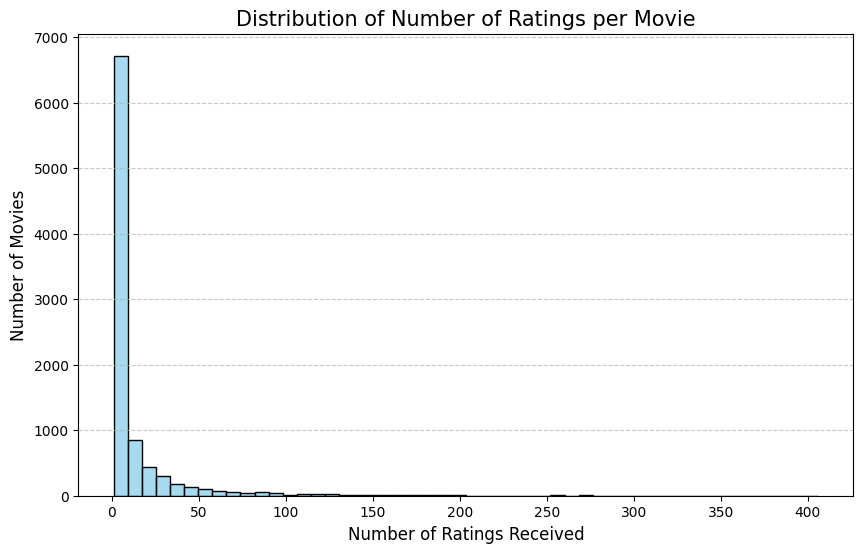

\nDescriptive statistics for ratings per movie:
count    9183.000000
mean       13.067625
std        29.021032
min         1.000000
25%         1.000000
50%         3.000000
75%        10.000000
max       406.000000
Name: count, dtype: float64


In [13]:
print("\\n--- Distribution of Number of Ratings per Movie ---")
movie_rating_counts = df_ratings['movieId'].value_counts()

plt.figure(figsize=(10, 6))
sns.histplot(movie_rating_counts, bins=50, kde=False, color='skyblue')
plt.title('Distribution of Number of Ratings per Movie', fontsize=15)
plt.xlabel('Number of Ratings Received', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("\\nDescriptive statistics for ratings per movie:")
print(movie_rating_counts.describe())

## **5. Distribution of Number of Ratings Given by Users**

\n--- Distribution of Number of Ratings Given by Users ---


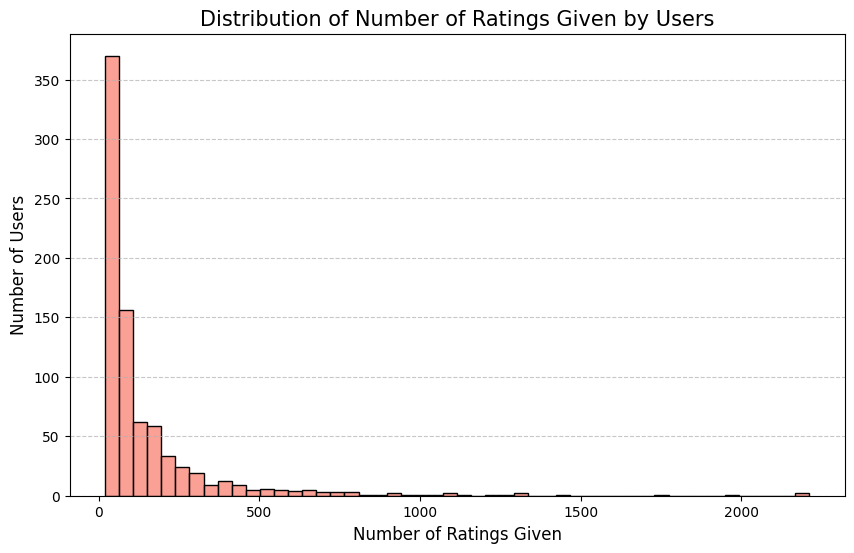

\nDescriptive statistics for ratings per user:
count     806.000000
mean      148.883375
std       233.707863
min        19.000000
25%        35.000000
50%        70.000000
75%       161.000000
max      2212.000000
Name: count, dtype: float64


In [14]:
print("\\n--- Distribution of Number of Ratings Given by Users ---")
user_activity_counts = df_ratings['userId'].value_counts()

plt.figure(figsize=(10, 6))
sns.histplot(user_activity_counts, bins=50, kde=False, color='salmon')
plt.title('Distribution of Number of Ratings Given by Users', fontsize=15)
plt.xlabel('Number of Ratings Given', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("\\nDescriptive statistics for ratings per user:")
print(user_activity_counts.describe())

- Visualisasi menggunakan `histplot` juga menunjukkan distribusi *long-tail*, di mana sebagian besar pengguna memberikan sejumlah kecil rating, sementara beberapa pengguna sangat aktif.
    - Rata-rata pengguna memberikan sekitar 148 rating, namun standar deviasinya juga tinggi.
    - *Insight*: Pengguna yang sangat aktif memberikan lebih banyak informasi untuk model Collaborative Filtering, tetapi sistem juga harus mampu menangani pengguna dengan sedikit riwayat.

## **6. Distribution of Movie Release Year**s

\n--- Distribution of Movie Release Years ---


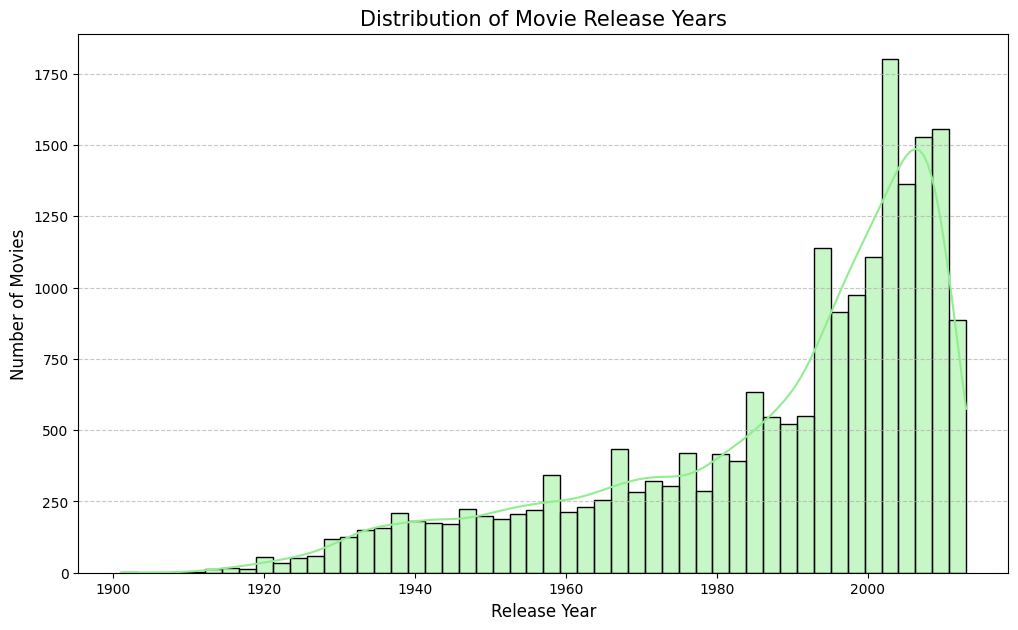

\nDescriptive statistics for movie release years:
count    19989.000000
mean      1987.485167
std         22.511688
min       1901.000000
25%       1975.000000
50%       1996.000000
75%       2005.000000
max       2013.000000
Name: year, dtype: float64


In [15]:
print("\\n--- Distribution of Movie Release Years ---")
# Attempt to extract year from title
movies_for_eda_years = df_movies.copy()
movies_for_eda_years['year_extract'] = movies_for_eda_years['title'].str.extract(r'\((\d{4})\)', expand=False)

# Convert extracted year to numeric, coercing errors to NaN
movies_for_eda_years['year'] = pd.to_numeric(movies_for_eda_years['year_extract'], errors='coerce')

# Filter out NaNs and potentially unrealistic years (e.g., before 1900 or future years if any)
valid_years = movies_for_eda_years.dropna(subset=['year'])
valid_years = valid_years[(valid_years['year'] >= 1900) & (valid_years['year'] <= pd.to_datetime('today').year)]

if not valid_years.empty:
    plt.figure(figsize=(12, 7))
    sns.histplot(data=valid_years, x='year', bins=50, kde=True, color='lightgreen')
    plt.title('Distribution of Movie Release Years', fontsize=15)
    plt.xlabel('Release Year', fontsize=12)
    plt.ylabel('Number of Movies', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    print("\\nDescriptive statistics for movie release years:")
    print(valid_years['year'].describe())
else:
    print("Could not extract enough valid years to plot a distribution.")

- Tahun rilis diekstrak dari judul film. Visualisasi `histplot` menunjukkan peningkatan jumlah film yang dirilis dari tahun ke tahun, dengan puncak di sekitar akhir 1990-an hingga awal 2000-an dalam subset data yang dimuat.
    - *Insight*: Informasi tahun rilis dapat digunakan sebagai fitur tambahan atau untuk menganalisis tren.

## **7. Temporal Distribution of Ratings**

Visualisasi ini menunjukkan jumlah film yang dirilis berdasarkan tahun

\n--- Temporal Distribution of Ratings ---


<ipython-input-16-c926f41cc426>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating_year', data=ratings_for_eda_time, palette='viridis')


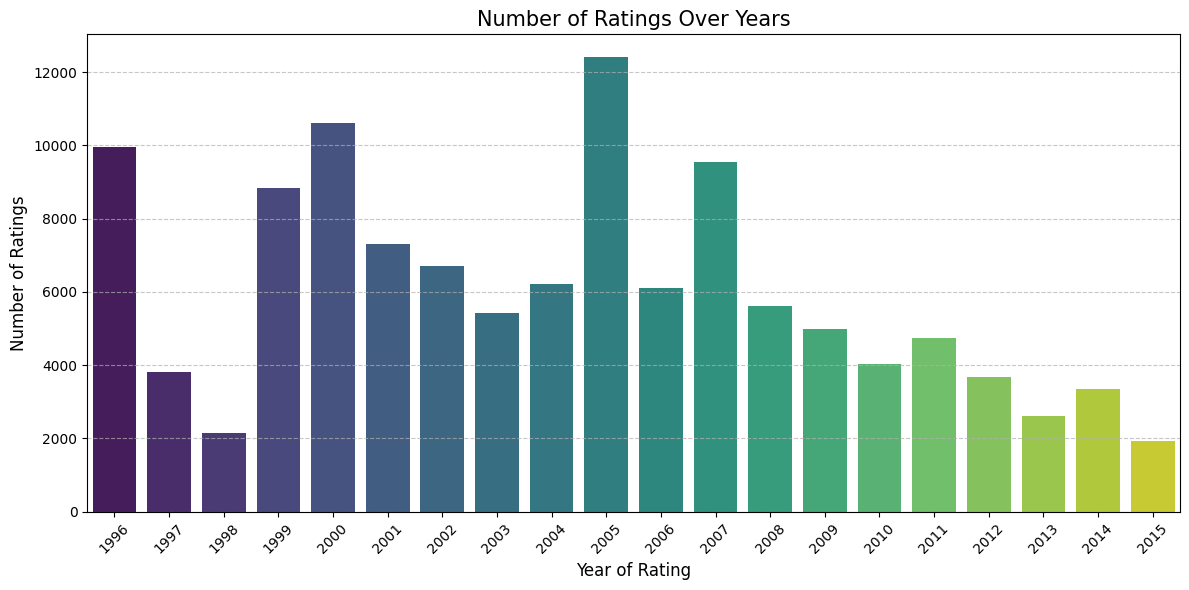

\nRating counts per year:
rating_year
1996     9941
1997     3811
1998     2158
1999     8841
2000    10596
2001     7309
2002     6700
2003     5416
2004     6205
2005    12409
2006     6117
2007     9541
2008     5626
2009     4999
2010     4022
2011     4739
2012     3668
2013     2614
2014     3362
2015     1926
Name: count, dtype: int64


In [16]:
print("\\n--- Temporal Distribution of Ratings ---")
ratings_for_eda_time = df_ratings.copy()
# Convert timestamp to datetime objects
ratings_for_eda_time['datetime'] = pd.to_datetime(ratings_for_eda_time['timestamp'])

# Extract year of rating
ratings_for_eda_time['rating_year'] = ratings_for_eda_time['datetime'].dt.year

if not ratings_for_eda_time.empty:
    plt.figure(figsize=(12, 6))
    sns.countplot(x='rating_year', data=ratings_for_eda_time, palette='viridis')
    plt.title('Number of Ratings Over Years', fontsize=15)
    plt.xlabel('Year of Rating', fontsize=12)
    plt.ylabel('Number of Ratings', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    print("\\nRating counts per year:")
    print(ratings_for_eda_time['rating_year'].value_counts().sort_index())
else:
    print("No rating data to analyze temporally.")


  - Rating dikelompokkan berdasarkan tahun pemberian rating. Visualisasi `countplot` menunjukkan fluktuasi jumlah rating yang diberikan setiap tahunnya, dengan puncak pada tahun 2005 dalam subset data yang dianalisis.
  - *Insight*: Pola temporal ini bisa menarik untuk analisis lebih lanjut.

EDA ini memberikan pemahaman yang baik tentang karakteristik dataset, distribusi fitur-fitur penting, dan potensi tantangan dalam membangun sistem rekomendasi.

# **3. PERSIAPAN DATA (DATA PREPARATION)**



Tahapan ini melibatkan pembersihan data, pemrosesan fitur, dan penyiapan dataset untuk model rekomendasi.

In [17]:
# Menggunakan df_ratings, df_movies_original, df_tags_original untuk persiapan
df_ratings_prep = df_ratings.copy()
df_movies_prep = df_movies.copy()
df_tags_prep = df_tags.copy()

## A. Pembersihan Data Awal

Menghapus nilai yang hilang dan duplikasi dari DataFrame utama.

In [18]:
#  kodek memeriksa nilai yang hilang (sebelum pembersihan)
print("Nilai yang hilang di df_ratings_prep:")
print(df_ratings_prep.isnull().sum())
print("\\nNilai yang hilang di df_movies_prep:")
print(df_movies_prep.isnull().sum())
print("\\nNilai yang hilang di df_tags_prep:")
print(df_tags_prep.isnull().sum())

Nilai yang hilang di df_ratings_prep:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
\nNilai yang hilang di df_movies_prep:
movieId    0
title      0
genres     0
dtype: int64
\nNilai yang hilang di df_tags_prep:
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64


In [19]:
# Potongan kode dari notebook untuk memeriksa duplikasi (sebelum pembersihan)
print("\\nJumlah baris duplikat di df_ratings_prep:")
print(df_ratings_prep.duplicated().sum())
print("\\nJumlah movieId duplikat di df_movies_prep:")
print(df_movies_prep.duplicated(subset=['movieId']).sum())

\nJumlah baris duplikat di df_ratings_prep:
0
\nJumlah movieId duplikat di df_movies_prep:
0


In [20]:
print("Melakukan pembersihan data awal (ratings, movies)...")
df_ratings_prep.dropna(inplace=True)
df_movies_prep.dropna(subset=['title', 'genres'], inplace=True)
df_ratings_prep.drop_duplicates(inplace=True)
df_movies_prep.drop_duplicates(subset=['movieId'], keep='first', inplace=True)

Melakukan pembersihan data awal (ratings, movies)...


Fungsi:
1. Menghapus nilai yang hilang:

  - Nilai hilang dalam data dapat mengurangi kualitas model.

  - dropna() digunakan untuk menghapus data yang memiliki nilai NaN.

2. Menghapus duplikasi:

  - Data duplikat tidak memberikan informasi tambahan sehingga dihapus untuk menghindari bias.

  - drop_duplicates() digunakan untuk menghapus data ganda.

Konteks DataFrame:
  - df_ratings_prep: Data rating yang sudah bersih.

  - df_movies_prep: Data film tanpa nilai kosong di kolom title dan genres.

  - df_tags_prep: Data tag dengan penanganan untuk nilai kosong.

Pentingnya:
- Nilai kosong atau duplikat dapat mengganggu analisis dan menurunkan performa model. Dengan membersihkan data, kita memastikan kualitas dataset.

## B. Pemrosesan Data Tags

Bagian ini digunakan untuk menggabungkan tag unik dari setiap film



In [21]:
print("Memproses data tags...")
df_tags_prep['tag'] = df_tags_prep['tag'].fillna('').astype(str).str.lower()
aggregated_tags = df_tags_prep[df_tags_prep['tag'] != ''].groupby('movieId')['tag'].apply(
    lambda tags_list: ' '.join(sorted(list(set(tags_list))))
).reset_index()
aggregated_tags.rename(columns={'tag': 'movie_tags'}, inplace=True)

Memproses data tags...


Kode ini menggabungkan semua tag unik dari setiap film menjadi satu string dalam kolom movie_tags:

- Membersihkan data tag: Mengisi nilai kosong dan mengubah teks menjadi huruf kecil.

- Menggabungkan tag: Menghapus duplikat, mengurutkan, dan menyatukan tag per movieId menggunakan spasi.

- Hasil akhir: Kolom movie_tags memperkaya informasi film untuk digunakan dalam Content-Based Filtering.

Fungsi:

- Menggabungkan semua tag unik dari setiap movieId menjadi satu string.

Kegunaan:

- Tag memberikan deskripsi tambahan untuk film, memperkaya informasi yang digunakan dalam Content-Based Filtering.

## C. Persiapan Data untuk Content-Based Filtering

Bagian ini digunakan untuk membuat kolom gabungan dari fitur fitur dari dataset

In [22]:
print("\nMempersiapkan data spesifik untuk Content-Based Filtering...")
movies_for_cb = pd.merge(df_movies, aggregated_tags, on='movieId', how='left')
movies_for_cb['movie_tags'] = movies_for_cb['movie_tags'].fillna('')

# Membuat fitur 'konten_gabungan' (soup) dari genre dan tags
movies_for_cb['konten_gabungan'] = (
    movies_for_cb['genres'].fillna('').astype(str).str.replace('|', ' ', regex=False) +
    ' ' +
    movies_for_cb['movie_tags']
)
movies_for_cb['konten_gabungan'] = movies_for_cb['konten_gabungan'].str.strip().str.replace(r'\s+', ' ', regex=True)

# DataFrame final untuk Content-Based, gunakan movieId sebagai index
movies_content_base = movies_for_cb[['movieId', 'title', 'genres', 'konten_gabungan']].copy()
movies_content_base = movies_content_base.drop_duplicates(subset='movieId').set_index('movieId')
print(f"DataFrame untuk Content-Based ('movies_content_base') siap dengan {len(movies_content_base)} film unik.")


Mempersiapkan data spesifik untuk Content-Based Filtering...
DataFrame untuk Content-Based ('movies_content_base') siap dengan 20000 film unik.


Code ini untuk :
- Menggabungkan data genre dan tag film menjadi satu kolom baru bernama konten_gabungan.

- Membersihkan teks: Menghapus nilai kosong, mengganti pemisah | dengan spasi, dan menghilangkan spasi berlebih.

- Menyusun DataFrame final: Memilih kolom penting (movieId, title, genres, konten_gabungan) dan memastikan data unik berdasarkan movieId.

Fungsi:

- Menggabungkan genre dan tag dalam satu kolom (konten_gabungan).

Kegunaan:

- konten_gabungan adalah inti dari Content-Based Filtering, karena menjadi sumber fitur utama untuk analisis teks.

## D. TF-IDF Vectorization untuk Content-Based

TF-IDF memastikan fitur yang lebih informatif mendominasi representasi konten, mendukung pengukuran kesamaan antar film secara efektif dengan mengurangi noise dan mengelola dimensi fitur.

In [23]:
print("\nMenerapkan TF-IDF Vectorization pada 'konten_gabungan'...")
tfidf_processor = TfidfVectorizer(stop_words='english', min_df=3, max_df=0.8, ngram_range=(1,2)) # Penyesuaian parameter
tfidf_features_cb = tfidf_processor.fit_transform(movies_content_base['konten_gabungan'])
print(f"Dimensi Matriks Fitur TF-IDF (Content-Based): {tfidf_features_cb.shape}")


Menerapkan TF-IDF Vectorization pada 'konten_gabungan'...
Dimensi Matriks Fitur TF-IDF (Content-Based): (20000, 3754)


Mengubah teks dari kolom konten_gabungan menjadi representasi numerik menggunakan TF-IDF.

Parameter:

- stop_words='english': Menghapus kata umum (stop words) berbahasa Inggris.

- min_df=3: Hanya mempertimbangkan kata yang muncul di setidaknya 3 dokumen.

- max_df=0.8: Mengabaikan kata yang terlalu sering muncul (>80% dokumen).

ngram_range=(1,2): Menggunakan unigram dan bigram.

Output:

- Matriks TF-IDF (tfidf_features_cb) berisi representasi numerik fitur teks dari setiap film.

Fungsi:

- Mengubah teks dari konten_gabungan menjadi representasi numerik menggunakan TF-IDF.

Kegunaan:

- TF-IDF mengukur relevansi kata dalam dokumen, memungkinkan model mengenali pola unik dalam deskripsi film.

## E. Persiapan Data untuk Collaborative Filtering

### **1. Persiapan Data untuk SVD**

Persiapan data untuk Collaborative Filtering dengan SVD menggunakan scikit-surprise mencakup langkah-langkah penyaringan pengguna dan film untuk mengurangi sparsitas data, memastikan kesesuaian format, serta membagi data menjadi set pelatihan dan pengujian guna membangun dan mengevaluasi model secara efektif

In [24]:
print("\nMempersiapkan data untuk Collaborative Filtering (SVD - scikit-surprise)...")
min_ratings_per_user = 3
user_rating_counts = df_ratings['userId'].value_counts()
active_users = user_rating_counts[user_rating_counts >= min_ratings_per_user].index

df_ratings_cf_surprise = df_ratings[
    (df_ratings['movieId'].isin(movies_content_base.index)) &
    (df_ratings['userId'].isin(active_users))
].copy()

if not df_ratings_cf_surprise.empty:
    min_rating_val = df_ratings_cf_surprise['rating'].min()
    max_rating_val = df_ratings_cf_surprise['rating'].max()
    reader_surprise = Reader(rating_scale=(min_rating_val, max_rating_val))
    data_surprise_format = Dataset.load_from_df(df_ratings_cf_surprise[['userId', 'movieId', 'rating']], reader_surprise)
    #Split Data untuk SVD
    trainset_surprise, testset_surprise = surprise_train_test_split(data_surprise_format, test_size=0.2, random_state=42)
    print(f"Data untuk SVD: {trainset_surprise.n_ratings} training ratings, {len(testset_surprise)} test ratings.")
else:
    print("Tidak cukup data rating setelah filtering untuk SVD.")
    # Inisialisasi dummy jika tidak ada data, agar notebook tetap berjalan
    min_rating_val, max_rating_val = 0.5, 5.0
    trainset_surprise, testset_surprise = None, []



Mempersiapkan data untuk Collaborative Filtering (SVD - scikit-surprise)...
Data untuk SVD: 95390 training ratings, 23848 test ratings.


1. Filter Pengguna Aktif
Hanya menyertakan pengguna dengan minimal 3 rating untuk memastikan data relevan bagi Collaborative Filtering.
2. Filter Film Valid
Hanya film yang terdapat dalam movies_content_base yang dipertahankan.

3. Format Data untuk SVD
Data disesuaikan ke format scikit-surprise dengan triplet (userId, movieId, rating) dan skala rating ditentukan dari data.

4. Pembagian Data
Dataset dibagi menjadi 80% data pelatihan dan 20% data pengujian untuk membangun dan mengevaluasi model.

5. Penanganan Data Kosong
Jika data terlalu sedikit setelah penyaringan, dilakukan inisialisasi dummy untuk menghindari error.

Kegunaan
Menyiapkan data berkualitas untuk model SVD dalam Collaborative Filtering, mengurangi sparsitas, dan memfasilitasi evaluasi kinerja model.

### **2. Persiapan Data untuk Neural Collaborative Filtering (NCF)**

Persiapan data untuk NCF melibatkan penyaringan, encoding ID pengguna dan film ke integer, serta pembagian data menjadi set pelatihan dan validasi untuk memastikan kompatibilitas dengan model deep learning.

In [25]:
print("\n--- (BARU) D.1. Persiapan Data untuk Neural Collaborative Filtering (NCF) ---")
# Menggunakan data rating yang sudah difilter dari persiapan SVD (df_ratings_cf_surprise)
# atau jika belum ada, gunakan df_ratings_prep
if 'df_ratings_cf_surprise' in locals() and not df_ratings_cf_surprise.empty:
    df_ratings_ncf = df_ratings_cf_surprise.copy()
    print(f"Menggunakan df_ratings_cf_surprise untuk NCF, jumlah rating: {len(df_ratings_ncf)}")
else:
    # Jika df_ratings_cf_surprise tidak ada atau kosong, fallback ke df_ratings_prep
    # Pastikan df_ratings_prep sudah melalui proses cleaning yang memadai
    if 'df_ratings_prep' in locals() and not df_ratings_prep.empty:
        df_ratings_ncf = df_ratings_prep.copy()
        print(f"Menggunakan df_ratings_prep untuk NCF, jumlah rating: {len(df_ratings_ncf)}")
    else:
        # Fallback ke df_ratings jika yang lain tidak tersedia
        df_ratings_ncf = ratings.copy() # Gunakan ratings asli jika df_ratings_prep juga tidak ada
        df_ratings_ncf.dropna(inplace=True) # Pastikan tidak ada NaN
        df_ratings_ncf.drop_duplicates(inplace=True)
        print(f"Menggunakan df_ratings (asli yang sudah di-clean) untuk NCF, jumlah rating: {len(df_ratings_ncf)}")


--- (BARU) D.1. Persiapan Data untuk Neural Collaborative Filtering (NCF) ---
Menggunakan df_ratings_cf_surprise untuk NCF, jumlah rating: 119238


In [26]:
# Pemetaan userId ke integer yang berurutan
user_ids_ncf = df_ratings_ncf["userId"].unique().tolist()
user_to_user_encoded_ncf = {x: i for i, x in enumerate(user_ids_ncf)}
user_encoded_to_user_ncf = {i: x for i, x in enumerate(user_ids_ncf)}
df_ratings_ncf["user_encoded"] = df_ratings_ncf["userId"].map(user_to_user_encoded_ncf)
num_users_ncf = len(user_to_user_encoded_ncf)

# Pemetaan movieId ke integer yang berurutan
movie_ids_ncf_unique_from_ratings = df_ratings_ncf["movieId"].unique().tolist()

# Pastikan semua movieId ada di movies_content_base untuk mendapatkan info film
# Filter movie_ids_ncf agar hanya berisi movieId yang ada di movies_content_base
# Ini penting agar kita bisa mendapatkan info film untuk rekomendasi NCF nantinya
# Asumsi 'movies_content_base' sudah di-set index-nya dengan 'movieId'
valid_movie_ids_for_ncf = [mid for mid in movie_ids_ncf_unique_from_ratings if mid in movies_content_base.index]

movie_to_movie_encoded_ncf = {x: i for i, x in enumerate(valid_movie_ids_for_ncf)}
movie_encoded_to_movie_ncf = {i: x for i, x in enumerate(valid_movie_ids_for_ncf)}

# Filter df_ratings_ncf agar hanya menggunakan movieId yang valid
df_ratings_ncf = df_ratings_ncf[df_ratings_ncf["movieId"].isin(valid_movie_ids_for_ncf)].copy()
df_ratings_ncf["movie_encoded"] = df_ratings_ncf["movieId"].map(movie_to_movie_encoded_ncf)
num_movies_ncf = len(movie_to_movie_encoded_ncf)


print(f"Jumlah pengguna unik untuk NCF: {num_users_ncf}")
print(f"Jumlah film unik untuk NCF (setelah filter dengan movies_content_base): {num_movies_ncf}")

Jumlah pengguna unik untuk NCF: 806
Jumlah film unik untuk NCF (setelah filter dengan movies_content_base): 8908


In [27]:
# Mengubah kolom rating menjadi float
df_ratings_ncf["rating"] = df_ratings_ncf["rating"].values.astype(np.float32)

# Membagi data
# Pastikan tidak ada NaN di user_encoded atau movie_encoded setelah mapping
df_ratings_ncf.dropna(subset=['user_encoded', 'movie_encoded'], inplace=True)

X_ncf = df_ratings_ncf[["user_encoded", "movie_encoded"]].values
y_ncf = df_ratings_ncf["rating"].values


if len(X_ncf) > 0 and len(y_ncf) > 0 : #Hanya lakukan split jika ada data
    X_train_ncf, X_val_ncf, y_train_ncf, y_val_ncf = sklearn_train_test_split(
        X_ncf, y_ncf, test_size=0.1, random_state=42 # Menggunakan 10% untuk validasi TensorFlow
    )
    print(f"Ukuran data training NCF: {X_train_ncf.shape[0]}")
    print(f"Ukuran data validasi NCF: {X_val_ncf.shape[0]}")
else:
    print("Tidak cukup data untuk NCF setelah filtering dan encoding. Model NCF tidak akan dilatih.")
    X_train_ncf, X_val_ncf, y_train_ncf, y_val_ncf = (None, None, None, None) # Set ke None

Ukuran data training NCF: 107314
Ukuran data validasi NCF: 11924


**Persiapan Data NCF**
1. Pemilihan Dataset Awal
Gunakan dataset yang sudah difilter (df_ratings_cf_surprise). Jika tidak ada, fallback ke dataset yang tersedia (df_ratings_prep atau df_ratings).

2. Encoding ID Pengguna dan Film
ID pengguna (userId) dan film (movieId) diubah ke integer menggunakan mapping.
Hanya film yang valid (ada di movies_content_base) yang diproses.

3. Konversi Rating ke Float
Kolom rating diubah ke tipe float32 untuk kompatibilitas model.

4. Pembagian Dataset
Dataset dibagi menjadi 90% data pelatihan dan 10% data validasi menggunakan train_test_split.

5. Output Jumlah Data
Cetak jumlah pengguna, film unik, dan ukuran data pelatihan/validasi untuk verifikasi.

Kegunaan:
Encoding: Memastikan data sesuai dengan format TensorFlow.

Pembagian Data: Memisahkan data pelatihan dan validasi untuk evaluasi kinerja model.

In [28]:
print("--- Persiapan Data Selesai ---")

--- Persiapan Data Selesai ---


# **4. MODELING**

## **A. PEMODELAN - CONTENT-BASED FILTERING**

Model ini merekomendasikan item berdasarkan kemiripan atributnya dengan item yang telah disukai pengguna di masa lalu.

### **1**. **Perhitungan Matriks Similaritas (Cosine Similarity)**

modelan Content-Based Filtering menggunakan pendekatan berbasis fitur konten film. Dalam metode ini, setiap film direpresentasikan sebagai vektor fitur berdasarkan atribut tertentu (misalnya genre, sutradara, aktor) menggunakan teknik seperti TF-IDF. Matriks similarity dihitung menggunakan *cosine similarity* untuk menemukan tingkat kemiripan antar film.

In [29]:
print("Menghitung Matriks Cosine Similarity untuk Content-Based...")
cosine_similarity_matrix_cb = cosine_similarity(tfidf_features_cb, tfidf_features_cb)
print(f"Dimensi Matriks Cosine Similarity (Content-Based): {cosine_similarity_matrix_cb.shape}")

Menghitung Matriks Cosine Similarity untuk Content-Based...
Dimensi Matriks Cosine Similarity (Content-Based): (20000, 20000)


### **2**. **Pemetaan Judul Film ke Index Matriks (berdasarkan movieId)**

Judul film dipetakan ke indeks matriks dan sebaliknya untuk memudahkan pencarian serta rekomendasi film berdasarkan input pengguna.


In [30]:
# movies_content_base sudah diindeks oleh movieId. Kita perlu map dari title ke movieId.
title_to_movieid_lookup_cb = pd.Series(
    movies_content_base.index, index=movies_content_base['title']
).drop_duplicates()
movieid_to_title_lookup_cb = pd.Series(
    movies_content_base['title'], index=movies_content_base.index
)
print("Pemetaan judul film ke movieId dan sebaliknya untuk Content-Based telah dibuat.")
print("--- Pemodelan Content-Based Selesai ---")

Pemetaan judul film ke movieId dan sebaliknya untuk Content-Based telah dibuat.
--- Pemodelan Content-Based Selesai ---


 **Cara Kerja dan Parameter Content-Based Filtering**
1. **Cara Kerja:**
   - Ekstraksi fitur dilakukan menggunakan TF-IDF.
   - Similaritas antar film dihitung dengan *cosine similarity*.
   - Film-film serupa direkomendasikan berdasarkan kemiripan konten.

2. **Parameter:**
   - `TF-IDF Vectorizer`: Mengubah teks menjadi representasi numerik berbobot.
     - `max_features`: Jumlah maksimum fitur (misalnya, 5000).
     - `stop_words`: Kata-kata umum yang diabaikan.
   - `Cosine Similarity`: Mengukur tingkat kesamaan berbasis sudut antara vektor

**Insight:**
Content-Based Filtering sangat efektif untuk rekomendasi film baru tanpa bergantung pada data pengguna lainnya. Namun, pendekatan ini terbatas jika fitur konten tidak cukup deskriptif atau jika film yang diminati pengguna tidak memiliki kesamaan konten yang signifikan.


## **B. PEMODELAN - COLLABORATIVE FILTERING (RecommenderNet TensorFlow)**

Pemodelan - Collaborative Filtering (RecommenderNet)

### **1. Pelatihan Model Collaborative Filtering(SVD)**

Pendekatan Collaborative Filtering menggunakan Singular Value Decomposition (SVD) untuk mendekomposisi matriks rating pengguna-film menjadi representasi ruang laten.

In [31]:
print("\nMemulai Pemodelan Collaborative Filtering (SVD)...")
svd_model = SVD(n_factors=100, n_epochs=25, lr_all=0.005, reg_all=0.04, random_state=42)

if trainset_surprise:
    print("Melatih model SVD...")
    svd_model.fit(trainset_surprise)
    print("Pelatihan model SVD selesai.")
    print("Membuat prediksi pada test set menggunakan model SVD...")
    predictions_svd_testset = svd_model.test(testset_surprise)
else:
    print("Tidak ada trainset untuk SVD, model tidak dilatih.")
    predictions_svd_testset = []

print("--- Pemodelan Collaborative Filtering (SVD) Selesai ---")


Memulai Pemodelan Collaborative Filtering (SVD)...
Melatih model SVD...
Pelatihan model SVD selesai.
Membuat prediksi pada test set menggunakan model SVD...
--- Pemodelan Collaborative Filtering (SVD) Selesai ---


 **Cara Kerja dan Parameter Collaborative Filtering (SVD)**
1. **Cara Kerja:**
   - Matriks rating \(R\) dipecah menjadi tiga matriks (\(P\), \(\Sigma\), \(Q^T\)).
   - Prediksi rating dilakukan dengan merekonstruksi matriks \(R\).

2. **Parameter:**
   - `n_factors`: Dimensi ruang laten (misalnya, 100).
   - `n_epochs`: Jumlah iterasi pelatihan (misalnya, 25).
   - `lr_all`: *Learning rate* untuk optimasi (misalnya, 0.005).
   - `reg_all`: Regularisasi untuk menghindari *overfitting* (misalnya, 0.04).
**Insight:**
SVD memberikan hasil yang baik untuk dataset dengan interaksi pengguna-film yang kaya. Namun, model ini dapat kesulitan menangani skala besar atau data yang sangat spars. Keunggulannya adalah kecepatan pelatihan untuk dataset berukuran sedang.

## **C. PEMODELAN - COLLABORATIVE FILTERING (Neural Collaborative Filtering - NCF)**

Pendekatan NCF menggunakan arsitektur neural network untuk menangkap interaksi linier dan non-linier antara pengguna dan film. Model ini menggabungkan dua jalur: Generalized Matrix Factorization (GMF) dan Multi-Layer Perceptron (MLP).


--- (BARU) C. PEMODELAN - COLLABORATIVE FILTERING (NCF) ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding_mlp  │ (None, 1, 64)     │     51,584 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_embedding_mlp │ (None, 1, 64)     │    570,112 │ movie_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp_concatenate     │ (None, 1, 128)    │          0 │ user_embedding_m… │
│ (Concatenate)       │                   │            │ movie_embedding_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 128)       │          0 │ mlp_concatenate[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,256 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │        528 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding_gmf  │ (None, 1, 64)     │     51,584 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_embedding_gmf │ (None, 1, 64)     │    570,112 │ movie_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 16)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gmf_multiply        │ (None, 1, 64)     │          0 │ user_embedding_g… │
│ (Multiply)          │                   │            │ movie_embedding_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 8)         │        136 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 64)        │          0 │ gmf_multiply[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 8)         │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_gmf_mlp      │ (None, 72)        │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         73 │ concat_gmf_mlp[0… │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 1,254,465 (4.79 MB)

 Trainable params: 1,254,465 (4.79 MB)

 Non-trainable params: 0 (0.00 B)


Memulai pelatihan model NCF dengan 15 epoch dan batch size 128...
Epoch 1/15
839/839 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 5.5038 - root_mean_squared_error: 2.2923 - val_loss: 0.9340 - val_root_mean_squared_error: 0.9658
Epoch 2/15
839/839 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - loss: 1.5266 - root_mean_squared_error: 1.2343 - val_loss: 0.8209 - val_root_mean_squared_error: 0.9044
Epoch 3/15
839/839 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.9478 - root_mean_squared_error: 0.9715 - val_loss: 0.8273 - val_root_mean_squared_error: 0.9068
Epoch 4/15
839/839 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.5919 - root_mean_squared_error: 0.7658 - val_loss: 0.8675 - val_root_mean_squared_error: 0.9281
Epoch 5/15
839/839 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.3801 - root_mean_squared_error: 0.6113 - val_loss: 0.9116 - val_root_mean_squared_error: 0.9512
Pelatihan model NCF selesai.


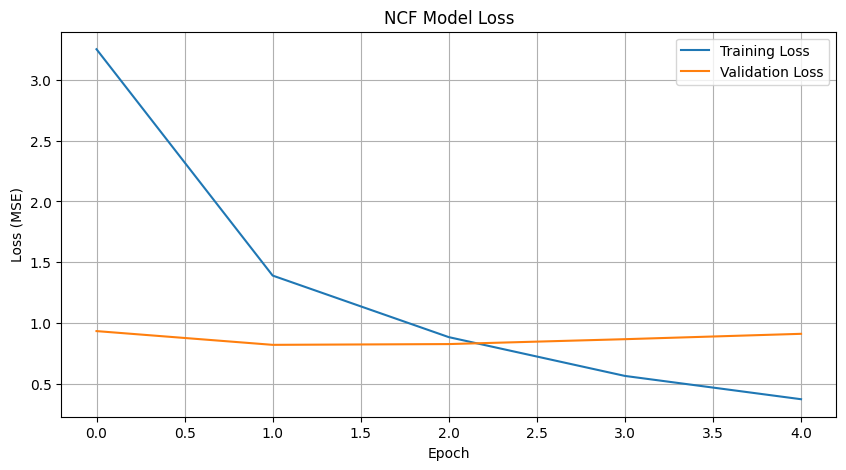

--- Pemodelan Collaborative Filtering (NCF) Selesai ---


In [32]:
print("\n--- (BARU) C. PEMODELAN - COLLABORATIVE FILTERING (NCF) ---")
if X_train_ncf is not None and num_users_ncf > 0 and num_movies_ncf > 0:
    def RecommenderNCF(num_users, num_movies, embedding_size=50, mlp_layers_sizes=[64, 32, 16, 8]):
        # Input layer
        user_input = layers.Input(shape=(1,), dtype='int32', name='user_input')
        movie_input = layers.Input(shape=(1,), dtype='int32', name='movie_input')

        # Embedding layers
        user_embedding_gmf = layers.Embedding(num_users, embedding_size,
                                           embeddings_initializer='he_normal',
                                           embeddings_regularizer=tf.keras.regularizers.l2(1e-6),
                                           name='user_embedding_gmf')(user_input)
        movie_embedding_gmf = layers.Embedding(num_movies, embedding_size,
                                            embeddings_initializer='he_normal',
                                            embeddings_regularizer=tf.keras.regularizers.l2(1e-6),
                                            name='movie_embedding_gmf')(movie_input)

        user_embedding_mlp = layers.Embedding(num_users, embedding_size,
                                           embeddings_initializer='he_normal',
                                           embeddings_regularizer=tf.keras.regularizers.l2(1e-6),
                                           name='user_embedding_mlp')(user_input)
        movie_embedding_mlp = layers.Embedding(num_movies, embedding_size,
                                            embeddings_initializer='he_normal',
                                            embeddings_regularizer=tf.keras.regularizers.l2(1e-6),
                                            name='movie_embedding_mlp')(movie_input)

        # GMF path
        gmf_vector = layers.Multiply(name='gmf_multiply')([user_embedding_gmf, movie_embedding_gmf])
        gmf_vector = layers.Flatten()(gmf_vector)

        # MLP path
        mlp_vector = layers.Concatenate(name='mlp_concatenate')([user_embedding_mlp, movie_embedding_mlp])
        mlp_vector = layers.Flatten()(mlp_vector)

        for layer_size in mlp_layers_sizes:
            mlp_vector = layers.Dense(layer_size, activation='relu',
                                    kernel_regularizer=tf.keras.regularizers.l2(1e-6))(mlp_vector)
            mlp_vector = layers.Dropout(0.3)(mlp_vector)

        # Concatenate GMF and MLP paths
        concat_vector = layers.Concatenate(name='concat_gmf_mlp')([gmf_vector, mlp_vector])
        output_layer = layers.Dense(1, kernel_initializer='lecun_uniform', name='output')(concat_vector)
        model = Model(inputs=[user_input, movie_input], outputs=output_layer)
        return model

    embedding_dim_ncf = 64
    model_ncf = RecommenderNCF(num_users_ncf, num_movies_ncf, embedding_size=embedding_dim_ncf)
    model_ncf.compile(optimizer=Adam(learning_rate=0.001),
                      loss=MeanSquaredError(),
                      metrics=[RootMeanSquaredError()])
    model_ncf.summary()

    batch_size_ncf = 128
    epochs_ncf = 15
    print(f"\nMemulai pelatihan model NCF dengan {epochs_ncf} epoch dan batch size {batch_size_ncf}...")
    X_train_ncf_keras = [X_train_ncf[:, 0], X_train_ncf[:, 1]]
    X_val_ncf_keras = [X_val_ncf[:, 0], X_val_ncf[:, 1]]

    history_ncf = model_ncf.fit(
        x=X_train_ncf_keras,
        y=y_train_ncf,
        batch_size=batch_size_ncf,
        epochs=epochs_ncf,
        verbose=1,
        validation_data=(X_val_ncf_keras, y_val_ncf),
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
    )
    print("Pelatihan model NCF selesai.")

    plt.figure(figsize=(10, 5))
    plt.plot(history_ncf.history['loss'], label='Training Loss')
    plt.plot(history_ncf.history['val_loss'], label='Validation Loss')
    plt.title('NCF Model Loss')
    plt.ylabel('Loss (MSE)')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()
else:
    print("Model NCF tidak dilatih karena tidak ada data training yang valid atau jumlah pengguna/film NCF adalah nol.")
    model_ncf = None # Tandai model NCF tidak ada

print("--- Pemodelan Collaborative Filtering (NCF) Selesai ---")

**Cara Kerja dan Parameter NCF**
1. **Cara Kerja:**
   - *User ID* dan *Movie ID* diubah menjadi representasi embedding.
   - Dua jalur digunakan:
     - **GMF Path:** Menangkap interaksi linier.
     - **MLP Path:** Menangkap interaksi non-linear melalui beberapa lapisan dense.
   - Hasil GMF dan MLP digabungkan untuk membuat prediksi.

2. **Parameter:**
   - `embedding_size`: Ukuran vektor embedding (misalnya, 64).
   - `mlp_layers_sizes`: Ukuran setiap lapisan dalam jalur MLP (misalnya, [64, 32, 16, 8]).
   - `dropout`: Persentase neuron yang dimatikan untuk mencegah *overfitting* (misalnya, 0.3).
   - `batch_size`: Jumlah sampel per batch pelatihan (misalnya, 128).
   - `epochs`: Jumlah iterasi pelatihan (misalnya, 15).

**Insight:**
NCF menawarkan kemampuan yang luar biasa untuk menangkap hubungan kompleks antar pengguna dan film. Namun, model ini membutuhkan banyak data pelatihan dan sumber daya komputasi. Model ini sangat cocok untuk skenario dengan data pengguna yang besar dan beragam.



# **5. FUNGSI-FUNGSI PENDUKUNG REKOMENDASI**

Mendefinisikan Fungsi-fungsi Pendukung Rekomendasi

## A. Fungsi untuk Rekomendasi Content-Based

In [33]:
def dapatkan_rekomendasi_content_based(judul_film_input, jumlah_rekomendasi=10,
                                    matriks_sim=cosine_similarity_matrix_cb,
                                    data_film_cb=movies_content_base,
                                    lookup_judul=title_to_movieid_lookup_cb):
    if judul_film_input not in lookup_judul:
        return f"Peringatan: Film '{judul_film_input}' tidak ditemukan."
    id_film_input = lookup_judul[judul_film_input]
    if isinstance(id_film_input, pd.Series): id_film_input = id_film_input.iloc[0]

    if id_film_input not in data_film_cb.index: return f"Peringatan: Movie ID '{id_film_input}' tidak valid."
    try:
        posisi_film_input = data_film_cb.index.get_loc(id_film_input)
    except KeyError: return f"Peringatan: Movie ID '{id_film_input}' tidak di index matriks."

    skor_similaritas_film = list(enumerate(matriks_sim[posisi_film_input]))
    skor_similaritas_film_sorted = sorted(skor_similaritas_film, key=lambda x: x[1], reverse=True)
    top_n_film_indices = [tpl[0] for tpl in skor_similaritas_film_sorted[1:jumlah_rekomendasi+1]]

    # Mengambil movieId dari index dan menyertakannya sebagai kolom
    df_hasil_rekomendasi = data_film_cb.iloc[top_n_film_indices].copy().reset_index()
    df_hasil_rekomendasi['Skor Similaritas'] = [tpl[1] for tpl in skor_similaritas_film_sorted[1:jumlah_rekomendasi+1]]
    return df_hasil_rekomendasi[['movieId', 'title', 'genres', 'Skor Similaritas']]


Fungsi ini bertujuan untuk menghasilkan rekomendasi film berbasis Content-Based Filtering, menggunakan skor cosine similarity untuk menentukan tingkat kemiripan antar film berdasarkan atributnya, seperti genre, sinopsis, atau metadata lain.

Fungsi menerima input berupa judul film yang ingin dijadikan referensi dan mengembalikan daftar film yang paling mirip dengan film tersebut.

In [34]:
def tampilkan_rekomendasi_cb_terformat(judul_film_input, jumlah_tampil=5):
    print("-" * 80)
    print(f"REKOMENDASI CONTENT-BASED untuk: '{judul_film_input}' (Top {jumlah_tampil})")
    print("-" * 80)
    hasil_df = dapatkan_rekomendasi_content_based(judul_film_input, jumlah_rekomendasi=jumlah_tampil)
    if isinstance(hasil_df, str): print(hasil_df)
    elif not hasil_df.empty:
        tabel_hasil = hasil_df.reset_index(drop=True); tabel_hasil.index += 1
        tabel_hasil = tabel_hasil.rename_axis('Peringkat').reset_index()
        tabel_hasil['Skor Similaritas'] = tabel_hasil['Skor Similaritas'].map('{:,.4f}'.format)
        print(tabel_hasil[['Peringkat', 'movieId', 'title', 'genres', 'Skor Similaritas']].to_string(index=False))
    else: print("Tidak ada rekomendasi Content-Based yang dapat ditampilkan.")
    print("-" * 80 + "\n")

Fungsi dapatkan_rekomendasi_content_based merekomendasikan film menggunakan pendekatan Content-Based Filtering dengan menghitung tingkat kemiripan (cosine similarity) antara film berdasarkan konten seperti genre. Dengan memasukkan judul film, fungsi ini akan memvalidasi judul tersebut, mengambil movieId, menghitung skor kemiripan terhadap film lain dalam matriks similarity, dan mengembalikan daftar film yang paling relevan. Hasil berupa dataframe berisi informasi movieId, title, genres, dan skor kemiripan, sesuai dengan jumlah rekomendasi yang diminta.

## B. Fungsi untuk Rekomendasi Collaborative Filtering (RecommenderNet)

In [35]:
def dapatkan_rekomendasi_svd(id_pengguna_asli, jumlah_rekomendasi=10,
                             model_svd_trained=svd_model,
                             data_trainset=trainset_surprise,
                             info_film_untuk_tampil=movies_content_base):
    if not data_trainset:
        print("Model SVD tidak dilatih karena tidak ada data training.")
        return pd.DataFrame(columns=['movieId', 'title', 'genres', 'Prediksi Rating'])

    daftar_semua_movie_id_raw = [data_trainset.to_raw_iid(inner_id) for inner_id in data_trainset.all_items()]
    film_sudah_dirating_raw_id = []
    try:
        inner_user_id = data_trainset.to_inner_uid(id_pengguna_asli)
        film_sudah_dirating_raw_id = [
            data_trainset.to_raw_iid(inner_item_id) for (inner_item_id, _) in data_trainset.ur[inner_user_id]
        ]
    except ValueError:
        print(f"Pengguna dengan ID {id_pengguna_asli} tidak ditemukan dalam data training.")
        return pd.DataFrame(columns=['movieId', 'title', 'genres', 'Prediksi Rating'])

    film_belum_dirating_raw_id = [
        movie_id for movie_id in daftar_semua_movie_id_raw if movie_id not in film_sudah_dirating_raw_id
    ]

    if not film_belum_dirating_raw_id:
        print(f"Pengguna {id_pengguna_asli} telah merating semua film atau tidak ada film baru untuk direkomendasikan.")
        return pd.DataFrame(columns=['movieId', 'title', 'genres', 'Prediksi Rating'])

    prediksi_pengguna = []
    for movie_id_raw in film_belum_dirating_raw_id:
        hasil_prediksi_obj = model_svd_trained.predict(uid=id_pengguna_asli, iid=movie_id_raw)
        prediksi_pengguna.append((movie_id_raw, hasil_prediksi_obj.est))

    prediksi_pengguna.sort(key=lambda x: x[1], reverse=True)
    top_n_prediksi_film = prediksi_pengguna[:jumlah_rekomendasi]

    id_film_rekomendasi_svd = [pred[0] for pred in top_n_prediksi_film]
    rating_prediksi_svd = [pred[1] for pred in top_n_prediksi_film]

    df_rekomendasi_final_svd = pd.DataFrame({
        'movieId': id_film_rekomendasi_svd,
        'Prediksi Rating': rating_prediksi_svd
    })

    df_rekomendasi_final_svd = pd.merge(
        df_rekomendasi_final_svd,
        info_film_untuk_tampil[['title', 'genres']].reset_index(),
        on='movieId',
        how='left'
    )
    df_rekomendasi_final_svd = df_rekomendasi_final_svd[['movieId', 'title', 'genres', 'Prediksi Rating']]
    return df_rekomendasi_final_svd.reset_index(drop=True)

Fungsi dapatkan_rekomendasi_svd menghasilkan daftar rekomendasi film untuk pengguna tertentu menggunakan pendekatan Collaborative Filtering berbasis model SVD. Dengan memanfaatkan model yang telah dilatih pada data pelatihan, fungsi ini memprediksi rating untuk film yang belum dirating oleh pengguna, mengurutkan hasil berdasarkan skor tertinggi, dan memilih sejumlah rekomendasi terbaik. Data prediksi digabungkan dengan informasi film seperti judul dan genre, lalu dikembalikan dalam bentuk dataframe berisi movieId, title, genres, dan Prediksi Rating.

In [36]:
def tampilkan_rekomendasi_svd_terformat(id_pengguna_asli, jumlah_tampil=5):
    print("-" * 90)
    print(f"REKOMENDASI COLLABORATIVE (SVD) untuk Pengguna ID: {id_pengguna_asli} (Top {jumlah_tampil})")
    print("-" * 90)
    hasil_df = dapatkan_rekomendasi_svd(id_pengguna_asli, jumlah_rekomendasi=jumlah_tampil)

    if hasil_df.empty:
        print(f"Tidak dapat menghasilkan rekomendasi SVD untuk Pengguna ID {id_pengguna_asli}.")
    else:
        tabel_hasil = hasil_df.reset_index(drop=True)
        tabel_hasil.index = tabel_hasil.index + 1
        tabel_hasil = tabel_hasil.rename_axis('Peringkat').reset_index()
        tabel_hasil['Prediksi Rating'] = tabel_hasil['Prediksi Rating'].map('{:,.3f}'.format)
        kolom_tampil = ['Peringkat', 'movieId', 'title', 'Prediksi Rating']
        if 'genres' in tabel_hasil.columns: kolom_tampil.insert(3, 'genres')
        print(tabel_hasil[kolom_tampil].to_string(index=False))
    print("-" * 90 + "\n")


Fungsi tampilkan_rekomendasi_svd_terformat memformat dan menampilkan hasil rekomendasi Collaborative Filtering untuk pengguna tertentu dengan tata letak tabel yang rapi dan informatif. Fungsi ini memanggil dapatkan_rekomendasi_svd untuk mendapatkan daftar rekomendasi, kemudian memeriksa ketersediaan data. Jika data tidak tersedia, fungsi menampilkan pesan peringatan, sementara jika tersedia, hasilnya diformat ke dalam tabel berisi peringkat, movieId, judul, genre, dan prediksi rating. Dengan demikian, fungsi ini memastikan rekomendasi dari model SVD disajikan secara jelas dan mudah dipahami.


## **C. Fungsi untuk Rekomendasi Neural Collaborative Filtering (NCF)**

In [37]:
# (BARU) C. Fungsi untuk Rekomendasi Neural Collaborative Filtering (NCF)
print("\n--- (BARU) C. Mendefinisikan Fungsi Rekomendasi NCF ---")
def dapatkan_rekomendasi_ncf(user_id_asli, jumlah_rekomendasi=10,
                             model_ncf_trained=model_ncf, # Gunakan model_ncf yang sudah dilatih
                             user_map_asli_ke_encoded=user_to_user_encoded_ncf,
                             movie_map_encoded_ke_asli=movie_encoded_to_movie_ncf,
                             # movie_map_asli_ke_encoded = movie_to_movie_encoded_ncf, # Tidak selalu dibutuhkan di sini
                             info_film_untuk_tampil=movies_content_base,
                             df_ratings_info=df_ratings_ncf): # Gunakan df_ratings_ncf yang sudah di-encode

    if model_ncf_trained is None:
        print("Model NCF tidak tersedia (belum dilatih).")
        return pd.DataFrame(columns=['movieId', 'title', 'genres', 'Prediksi Rating (NCF)'])

    if user_id_asli not in user_map_asli_ke_encoded:
        print(f"Pengguna dengan ID asli {user_id_asli} tidak ditemukan dalam pemetaan NCF.")
        return pd.DataFrame(columns=['movieId', 'title', 'genres', 'Prediksi Rating (NCF)'])

    user_encoded_id = user_map_asli_ke_encoded[user_id_asli]

    film_sudah_dirating_user_asli = df_ratings_info[df_ratings_info['userId'] == user_id_asli]['movieId'].unique()

    semua_movie_id_encoded_ncf = list(movie_map_encoded_ke_asli.keys())

    film_belum_dirating_encoded = [
        movie_enc for movie_enc in semua_movie_id_encoded_ncf
        if movie_map_encoded_ke_asli.get(movie_enc) not in film_sudah_dirating_user_asli
    ]

    if not film_belum_dirating_encoded:
        print(f"Pengguna {user_id_asli} telah merating semua film yang ada di model NCF atau tidak ada film baru.")
        return pd.DataFrame(columns=['movieId', 'title', 'genres', 'Prediksi Rating (NCF)'])

    user_array_ncf = np.array([user_encoded_id] * len(film_belum_dirating_encoded))
    movie_array_ncf = np.array(film_belum_dirating_encoded)

    prediksi_ncf = model_ncf_trained.predict([user_array_ncf, movie_array_ncf], verbose=0).flatten()

    hasil_prediksi_df = pd.DataFrame({
        'movie_encoded': film_belum_dirating_encoded,
        'prediksi_rating_ncf': prediksi_ncf
    })

    top_n_prediksi_film_ncf = hasil_prediksi_df.sort_values(by='prediksi_rating_ncf', ascending=False).head(jumlah_rekomendasi)
    top_n_prediksi_film_ncf['movieId'] = top_n_prediksi_film_ncf['movie_encoded'].map(movie_map_encoded_ke_asli)

    # Pastikan info_film_untuk_tampil memiliki 'movieId' sebagai kolom jika belum di-reset index-nya
    if info_film_untuk_tampil.index.name == 'movieId':
        info_film_df = info_film_untuk_tampil.reset_index()
    else:
        info_film_df = info_film_untuk_tampil.copy()

    df_rekomendasi_final_ncf = pd.merge(
        top_n_prediksi_film_ncf[['movieId', 'prediksi_rating_ncf']],
        info_film_df[['movieId', 'title', 'genres']],
        on='movieId',
        how='left'
    )
    df_rekomendasi_final_ncf.rename(columns={'prediksi_rating_ncf': 'Prediksi Rating (NCF)'}, inplace=True)

    return df_rekomendasi_final_ncf[['movieId', 'title', 'genres', 'Prediksi Rating (NCF)']].reset_index(drop=True)


def tampilkan_rekomendasi_ncf_terformat(user_id_asli, jumlah_tampil=5):
    print("-" * 95)
    print(f"REKOMENDASI NEURAL COLLABORATIVE FILTERING (NCF) untuk Pengguna ID: {user_id_asli} (Top {jumlah_tampil})")
    print("-" * 95)
    hasil_df_ncf = dapatkan_rekomendasi_ncf(user_id_asli, jumlah_rekomendasi=jumlah_tampil)

    if hasil_df_ncf.empty:
        print(f"Tidak dapat menghasilkan rekomendasi NCF untuk Pengguna ID {user_id_asli}.")
    else:
        tabel_hasil_ncf = hasil_df_ncf.reset_index(drop=True)
        tabel_hasil_ncf.index = tabel_hasil_ncf.index + 1
        tabel_hasil_ncf = tabel_hasil_ncf.rename_axis('Peringkat').reset_index()
        tabel_hasil_ncf['Prediksi Rating (NCF)'] = tabel_hasil_ncf['Prediksi Rating (NCF)'].map('{:,.3f}'.format)
        kolom_tampil_ncf = ['Peringkat', 'movieId', 'title', 'genres', 'Prediksi Rating (NCF)']
        print(tabel_hasil_ncf[kolom_tampil_ncf].to_string(index=False))
    print("-" * 95 + "\\n")

print("Fungsi rekomendasi NCF telah siap.")


--- (BARU) C. Mendefinisikan Fungsi Rekomendasi NCF ---
Fungsi rekomendasi NCF telah siap.


Fungsi dapatkan_rekomendasi_ncf menghasilkan daftar rekomendasi film untuk pengguna tertentu menggunakan pendekatan Neural Collaborative Filtering (NCF). Fungsi ini memprediksi rating film yang belum dirating oleh pengguna berdasarkan model NCF yang telah dilatih. Langkah kerja meliputi validasi ketersediaan model dan pengguna, identifikasi film yang belum dirating, prediksi rating menggunakan model NCF, dan seleksi hasil berdasarkan skor tertinggi. Data prediksi kemudian digabungkan dengan informasi film (judul dan genre) untuk menghasilkan dataframe rekomendasi dengan kolom movieId, title, genres, dan Prediksi Rating (NCF). Fungsi tampilkan_rekomendasi_ncf_terformat memformat hasil rekomendasi ini menjadi tabel rapi, menampilkan peringkat, judul, genre, dan prediksi rating, sehingga memudahkan interpretasi oleh pengguna.

## **D. Fungsi Hybrid**

In [38]:
def dapatkan_rekomendasi_hybrid(id_pengguna_asli, judul_film_referensi_cb, jumlah_rekomendasi=10,
                                w_svd=0.6, w_cb=0.4, # Bobot bisa disesuaikan
                                data_film_info=movies_content_base,
                                rating_min=min_rating_val, rating_max=max_rating_val):
    # 1. Dapatkan rekomendasi SVD
    svd_recs_df = dapatkan_rekomendasi_svd(id_pengguna_asli, jumlah_rekomendasi=jumlah_rekomendasi * 2) # Ambil lebih banyak untuk di-rank ulang
    if svd_recs_df.empty:
        svd_df_processed = pd.DataFrame(columns=['movieId', 'norm_svd_score'])
    else:
        svd_df_processed = svd_recs_df[['movieId', 'Prediksi Rating']].copy()
        svd_df_processed.rename(columns={'Prediksi Rating': 'svd_score'}, inplace=True)
        # Normalisasi skor SVD ke rentang 0-1
        svd_df_processed['norm_svd_score'] = (svd_df_processed['svd_score'] - rating_min) / (rating_max - rating_min)
        svd_df_processed = svd_df_processed[['movieId', 'norm_svd_score']]


    # 2. Dapatkan rekomendasi Content-Based
    cb_recs_df_raw = dapatkan_rekomendasi_content_based(judul_film_referensi_cb, jumlah_rekomendasi=jumlah_rekomendasi * 2)
    if isinstance(cb_recs_df_raw, str) or cb_recs_df_raw.empty:
         cb_df_processed = pd.DataFrame(columns=['movieId', 'cb_score'])
    else:
        cb_df_processed = cb_recs_df_raw[['movieId', 'Skor Similaritas']].copy()
        cb_df_processed.rename(columns={'Skor Similaritas': 'cb_score'}, inplace=True)

    # 3. Gabungkan rekomendasi
    # Pastikan movieId unik jika ada duplikasi dari sumber yang berbeda
    # Outer merge untuk mengambil semua film dari kedua sistem
    merged_df = pd.merge(svd_df_processed, cb_df_processed, on='movieId', how='outer')
    merged_df[['norm_svd_score', 'cb_score']] = merged_df[['norm_svd_score', 'cb_score']].fillna(0)

    # 4. Hitung skor hybrid
    merged_df['hybrid_score'] = (w_svd * merged_df['norm_svd_score']) + (w_cb * merged_df['cb_score'])

    # 5. Urutkan dan ambil top N
    top_hybrid_recs = merged_df.sort_values(by='hybrid_score', ascending=False).head(jumlah_rekomendasi)

    # 6. Gabungkan dengan informasi film
    final_df = pd.merge(top_hybrid_recs[['movieId', 'hybrid_score', 'norm_svd_score', 'cb_score']],
                        data_film_info.reset_index()[['movieId', 'title', 'genres']],
                        on='movieId',
                        how='left')
    return final_df[['movieId', 'title', 'genres', 'hybrid_score', 'norm_svd_score', 'cb_score']].reset_index(drop=True)




Fungsi dapatkan_rekomendasi_hybrid menggabungkan rekomendasi dari dua metode, yaitu Collaborative Filtering berbasis SVD dan Content-Based Filtering, dengan bobot tertentu untuk masing-masing (default SVD 0.6 dan CB 0.4). Fungsi mengambil rekomendasi dari kedua metode, menormalkan skor SVD, lalu menggabungkan dan menghitung skor hybrid sebagai kombinasi bobot dari kedua skor tersebut. Hasilnya diurutkan dan dikembalikan bersama informasi film (judul dan genre). Fungsi

In [39]:
def tampilkan_rekomendasi_hybrid_terformat(id_pengguna_asli, judul_film_referensi_cb, jumlah_tampil=5, w_svd=0.6, w_cb=0.4):
    print("-" * 110)
    print(f"REKOMENDASI HYBRID untuk Pengguna ID: {id_pengguna_asli}, Ref CB: '{judul_film_referensi_cb}' (Top {jumlah_tampil})")
    print(f"Bobot: SVD={w_svd}, CB={w_cb}")
    print("-" * 110)
    hasil_df = dapatkan_rekomendasi_hybrid(id_pengguna_asli, judul_film_referensi_cb,
                                          jumlah_rekomendasi=jumlah_tampil, w_svd=w_svd, w_cb=w_cb)

    if hasil_df.empty:
        print(f"Tidak dapat menghasilkan rekomendasi hybrid untuk Pengguna ID {id_pengguna_asli} dengan referensi '{judul_film_referensi_cb}'.")
    else:
        tabel_hasil = hasil_df.reset_index(drop=True)
        tabel_hasil.index = tabel_hasil.index + 1
        tabel_hasil = tabel_hasil.rename_axis('Peringkat').reset_index()
        tabel_hasil['hybrid_score'] = tabel_hasil['hybrid_score'].map('{:,.4f}'.format)
        tabel_hasil['norm_svd_score'] = tabel_hasil['norm_svd_score'].map('{:,.3f}'.format)
        tabel_hasil['cb_score'] = tabel_hasil['cb_score'].map('{:,.3f}'.format)

        kolom_tampil = ['Peringkat', 'movieId', 'title', 'genres', 'hybrid_score', 'norm_svd_score', 'cb_score']
        print(tabel_hasil[kolom_tampil].to_string(index=False))
    print("-" * 110 + "\n")

print("Fungsi-fungsi pendukung rekomendasi (termasuk Hybrid) telah siap.")

Fungsi-fungsi pendukung rekomendasi (termasuk Hybrid) telah siap.


tampilkan_rekomendasi_hybrid_terformat menampilkan hasil rekomendasi hybrid ini dalam format tabel rapi yang memuat peringkat, movieId, judul, genre, skor hybrid, serta skor masing-masing metode, memudahkan pengguna memahami dan membandingkan kontribusi kedua pendekatan dalam rekomendasi.

# **6. EVALUASI KINERJA MODEL**

Mengevaluasi Kinerja Model

## **A. Evaluasi Model Collaborative Filtering (SVD)**

Evaluasi model Collaborative Filtering (SVD) dilakukan dengan metrik RMSE dan MAE untuk mengukur akurasi prediksi rating. RMSE menghitung standar deviasi error prediksi dengan bobot lebih pada error besar, sementara MAE mengukur rata-rata selisih absolut antara prediksi dan nilai asli, yang lebih tahan terhadap outlier. Metrik dihitung menggunakan predictions_svd_testset dengan hasil ditampilkan dalam format teks dan divisualisasikan melalui grafik batang. Jika data tidak mencukupi, evaluasi akan menampilkan pesan peringatan dan menetapkan nilai placeholder -1.0 untuk RMSE dan MAE. Nilai metrik yang lebih kecil mencerminkan kinerja model yang lebih baik.


Mengevaluasi Model SVD pada test set...
RMSE: 0.9077
MAE:  0.7014

SVD Model Performance: RMSE = 0.9077, MAE = 0.7014


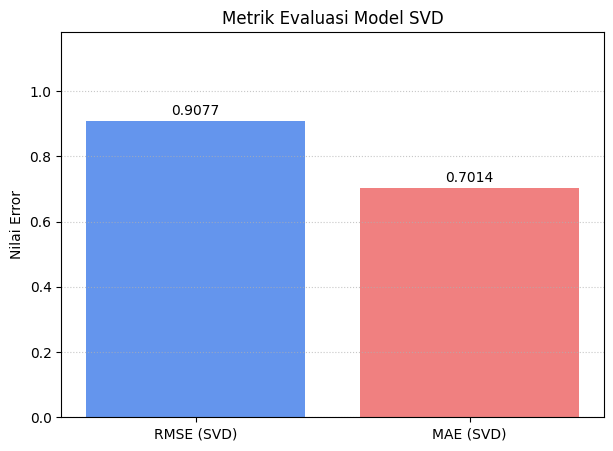

In [40]:
print("\nMengevaluasi Model SVD pada test set...")
if predictions_svd_testset:
    rmse_svd_value = accuracy.rmse(predictions_svd_testset, verbose=True)
    mae_svd_value = accuracy.mae(predictions_svd_testset, verbose=True)
    print(f"\nSVD Model Performance: RMSE = {rmse_svd_value:.4f}, MAE = {mae_svd_value:.4f}")

    plt.figure(figsize=(7, 5))
    metrics_names = ['RMSE (SVD)', 'MAE (SVD)']
    metrics_values = [rmse_svd_value, mae_svd_value]
    bars = plt.bar(metrics_names, metrics_values, color=['cornflowerblue', 'lightcoral'])
    plt.ylabel('Nilai Error')
    plt.title('Metrik Evaluasi Model SVD')
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.4f}', ha='center', va='bottom')
    plt.ylim(0, max(metrics_values) * 1.3 if metrics_values else 1.3)
    plt.grid(axis='y', linestyle=':', alpha=0.7)
    plt.show()
else:
    print("Tidak ada prediksi SVD untuk dievaluasi.")
    rmse_svd_value, mae_svd_value = -1.0, -1.0 # Nilai placeholder


## **B. Evaluasi Model Neural Collaborative Filtering (NCF)**

Evaluasi model Neural Collaborative Filtering (NCF) dilakukan menggunakan metrik berbasis error seperti Loss (MSE), RMSE, dan MAE untuk mengukur performa model pada validation set. Loss (MSE) menghitung rata-rata kesalahan kuadrat, RMSE mengevaluasi standar deviasi error dengan bobot lebih pada error besar, sedangkan MAE menghitung rata-rata selisih absolut antara prediksi dan nilai asli, yang lebih robust terhadap outlier. Metrik dihitung melalui evaluasi model pada validation set dengan hasil ditampilkan dalam format teks dan divisualisasikan menggunakan grafik batang. Jika data atau model tidak mencukupi, evaluasi akan menampilkan pesan peringatan dan menetapkan nilai placeholder -1.0 untuk RMSE dan MAE. Nilai metrik yang lebih kecil mencerminkan performa model yang lebih baik.


--- Evaluasi Model NCF ---
NCF Model Performance on Validation Set: Loss (MSE) = 0.8209, RMSE = 0.9044
NCF Model MAE on Validation Set: 0.7076


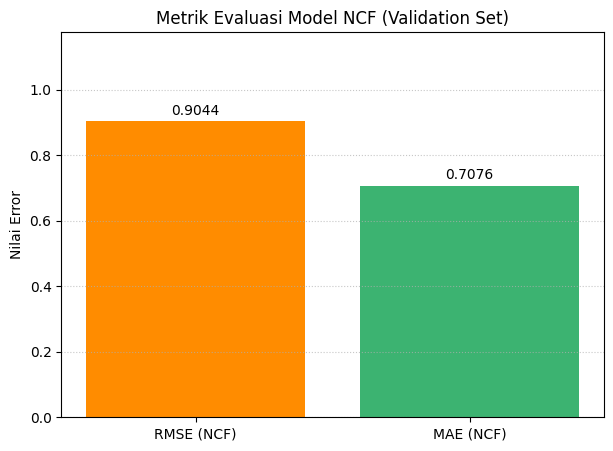

In [41]:
print("\n--- Evaluasi Model NCF ---")

if model_ncf is not None and X_val_ncf is not None:
    # Siapkan input untuk model Keras (list of arrays: [userId, movieId])
    X_val_ncf_keras_eval = [X_val_ncf[:, 0], X_val_ncf[:, 1]]

    # Evaluasi model (mengembalikan loss dan metric yang digunakan saat compile, misal RMSE)
    val_loss_ncf, val_rmse_ncf = model_ncf.evaluate(X_val_ncf_keras_eval, y_val_ncf, verbose=0)
    print(f"NCF Model Performance on Validation Set: Loss (MSE) = {val_loss_ncf:.4f}, RMSE = {val_rmse_ncf:.4f}")

    # Prediksi untuk menghitung MAE manual
    y_pred_val_ncf = model_ncf.predict(X_val_ncf_keras_eval, verbose=0).flatten()

    # Hitung MAE secara manual (pakai keras.metrics.MeanAbsoluteError sebagai class)
    mae_ncf_metric = tf.keras.metrics.MeanAbsoluteError()
    mae_ncf_metric.update_state(y_val_ncf, y_pred_val_ncf)
    mae_ncf_value = mae_ncf_metric.result().numpy()

    print(f"NCF Model MAE on Validation Set: {mae_ncf_value:.4f}")

    # Plot metrik evaluasi
    plt.figure(figsize=(7, 5))
    metrics_names_ncf_eval = ['RMSE (NCF)', 'MAE (NCF)']
    metrics_values_ncf_eval = [val_rmse_ncf, mae_ncf_value]

    bars_ncf = plt.bar(metrics_names_ncf_eval, metrics_values_ncf_eval, color=['darkorange', 'mediumseagreen'])
    plt.ylabel('Nilai Error')
    plt.title('Metrik Evaluasi Model NCF (Validation Set)')

    for bar in bars_ncf:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.4f}', ha='center', va='bottom')

    plt.ylim(0, max(metrics_values_ncf_eval) * 1.3)
    plt.grid(axis='y', linestyle=':', alpha=0.7)
    plt.show()

else:
    print("Model NCF tidak dievaluasi karena tidak dilatih.")
    val_rmse_ncf, mae_ncf_value = -1.0, -1.0  # Placeholder


## C. **Evaluasi Model Content-Based Filtering - Precision@K (Simulasi)**

Evaluasi Content-Based Filtering menggunakan Precision@K dilakukan untuk mengukur kualitas rekomendasi dengan menghitung persentase item relevan di antara K rekomendasi teratas. Model dievaluasi dengan memilih pengguna sampel, menentukan item relevan (rating ≥ 4), dan menghasilkan rekomendasi berdasarkan satu item relevan sebagai referensi. Precision rata-rata dihitung dan ditampilkan dalam format teks serta divisualisasikan melalui grafik batang. Jika data atau pengguna tidak mencukupi, evaluasi akan memberikan pesan peringatan dengan nilai Precision default 0.0. Nilai Precision@K yang lebih tinggi menunjukkan efektivitas model yang lebih baik dalam memberikan rekomendasi yang relevan.

In [42]:
print("\nMengevaluasi Model Content-Based Filtering (Precision@K)...")
def hitung_precision_at_k_cb(jumlah_rekomendasi_dihasilkan=5, K_untuk_precision=5, jumlah_pengguna_sampel=20, # Kurangi sampel
                            data_ratings_eval=df_ratings_cf_surprise, data_film_eval=movies_content_base,
                            lookup_judul_eval=title_to_movieid_lookup_cb):
    if data_ratings_eval.empty or data_film_eval.empty:
        print("Tidak cukup data untuk evaluasi CB.")
        return 0.0
    kumpulan_precision = []
    id_pengguna_valid_sampel = data_ratings_eval['userId'].unique()
    if len(id_pengguna_valid_sampel) == 0: return 0.0
    if len(id_pengguna_valid_sampel) < jumlah_pengguna_sampel:
        jumlah_pengguna_sampel = max(1, len(id_pengguna_valid_sampel))

    id_pengguna_dipilih_sampel = np.random.choice(id_pengguna_valid_sampel, size=jumlah_pengguna_sampel, replace=False)
    pengguna_berhasil_diproses = 0

    for id_user_eval in id_pengguna_dipilih_sampel:
        rating_user_eval = data_ratings_eval[data_ratings_eval['userId'] == id_user_eval]
        item_relevan_pengguna = set(rating_user_eval[rating_user_eval['rating'] >= 4.0]['movieId'].tolist())
        if not item_relevan_pengguna: continue

        # Ambil satu film yang disukai pengguna sebagai referensi CB
        id_film_query_cb = list(item_relevan_pengguna)[0]
        if id_film_query_cb not in data_film_eval.index: continue # Pastikan movieId ada di movies_content_base
        judul_film_query_cb_series = data_film_eval.loc[id_film_query_cb, 'title']
        judul_film_query_cb = judul_film_query_cb_series if isinstance(judul_film_query_cb_series, str) else judul_film_query_cb_series.iloc[0]

        df_rekomendasi_eval_cb = dapatkan_rekomendasi_content_based(judul_film_query_cb, jumlah_rekomendasi=jumlah_rekomendasi_dihasilkan)
        if isinstance(df_rekomendasi_eval_cb, str) or df_rekomendasi_eval_cb.empty: continue

        id_film_hasil_rekom_cb = df_rekomendasi_eval_cb['movieId'].tolist()
        if not id_film_hasil_rekom_cb:
            kumpulan_precision.append(0.0)
            continue

        jumlah_hits = len(item_relevan_pengguna.intersection(set(id_film_hasil_rekom_cb[:K_untuk_precision])))
        nilai_precision_at_k = jumlah_hits / K_untuk_precision if K_untuk_precision > 0 else 0.0
        kumpulan_precision.append(nilai_precision_at_k)
        pengguna_berhasil_diproses +=1

    if pengguna_berhasil_diproses < jumlah_pengguna_sampel * 0.2 and jumlah_pengguna_sampel > 0:
        print(f"PERINGATAN: Hanya {pengguna_berhasil_diproses} dari {jumlah_pengguna_sampel} pengguna berhasil diproses utk eval CB.")
    return np.mean(kumpulan_precision) if kumpulan_precision else 0.0

precision_at_5_cb_value = hitung_precision_at_k_cb(jumlah_rekomendasi_dihasilkan=5, K_untuk_precision=5, jumlah_pengguna_sampel=10) # Kurangi sampel
print(f"Content-Based Filtering (Simulasi) - Rata-rata Precision@5: {precision_at_5_cb_value:.4f}")


Mengevaluasi Model Content-Based Filtering (Precision@K)...
Content-Based Filtering (Simulasi) - Rata-rata Precision@5: 0.1800


## **D. Evaluasi Hybrid**

Evaluasi Model Hybrid Filtering - Precision@K
Model Hybrid Filtering menggabungkan SVD dan Content-Based Filtering dengan bobot tertentu untuk menghasilkan rekomendasi yang lebih akurat. Precision@K mengukur proporsi rekomendasi yang relevan di antara K item teratas.

Pada kode, Precision dihitung dengan memilih pengguna sampel, menentukan item relevan (rating ≥ 4), menghasilkan rekomendasi hybrid, dan mengevaluasi proporsi item relevan dalam rekomendasi. Hasil Precision rata-rata ditampilkan, dengan peringatan jika pengguna yang diproses kurang dari 20%. Jika data tidak mencukupi, nilai Precision default adalah 0.0.

In [43]:
print("\nMengevaluasi Model Hybrid Filtering (Precision@K)...")
def hitung_precision_at_k_hybrid(K_untuk_precision=5, jumlah_pengguna_sampel=10, # Kurangi sampel
                                 data_ratings_eval=df_ratings_cf_surprise, data_film_eval=movies_content_base,
                                 w_svd=0.6, w_cb=0.4):
    if data_ratings_eval.empty or data_film_eval.empty:
        print("Tidak cukup data untuk evaluasi Hybrid.")
        return 0.0
    kumpulan_precision = []
    id_pengguna_valid_sampel = data_ratings_eval['userId'].unique()
    if len(id_pengguna_valid_sampel) == 0: return 0.0
    if len(id_pengguna_valid_sampel) < jumlah_pengguna_sampel:
        jumlah_pengguna_sampel = max(1, len(id_pengguna_valid_sampel))

    id_pengguna_dipilih_sampel = np.random.choice(id_pengguna_valid_sampel, size=jumlah_pengguna_sampel, replace=False)
    pengguna_berhasil_diproses = 0

    for id_user_eval in id_pengguna_dipilih_sampel:
        rating_user_eval = data_ratings_eval[data_ratings_eval['userId'] == id_user_eval]
        item_relevan_pengguna = set(rating_user_eval[rating_user_eval['rating'] >= 4.0]['movieId'].tolist())
        if not item_relevan_pengguna: continue

        id_film_referensi_cb_hybrid = list(item_relevan_pengguna)[0]
        if id_film_referensi_cb_hybrid not in data_film_eval.index: continue
        judul_film_referensi_cb_hybrid_series = data_film_eval.loc[id_film_referensi_cb_hybrid, 'title']
        judul_film_referensi_cb_hybrid = judul_film_referensi_cb_hybrid_series if isinstance(judul_film_referensi_cb_hybrid_series, str) else judul_film_referensi_cb_hybrid_series.iloc[0]

        df_rekomendasi_eval_hybrid = dapatkan_rekomendasi_hybrid(
            id_user_eval, judul_film_referensi_cb_hybrid,
            jumlah_rekomendasi=K_untuk_precision, w_svd=w_svd, w_cb=w_cb
        )

        if df_rekomendasi_eval_hybrid.empty:
            # print(f"Tidak ada rek hybrid untuk user {id_user_eval} & ref {judul_film_referensi_cb_hybrid}")
            kumpulan_precision.append(0.0)
            continue

        id_film_hasil_rekom_hybrid = df_rekomendasi_eval_hybrid['movieId'].tolist()
        if not id_film_hasil_rekom_hybrid:
            kumpulan_precision.append(0.0)
            continue

        jumlah_hits = len(item_relevan_pengguna.intersection(set(id_film_hasil_rekom_hybrid[:K_untuk_precision])))
        nilai_precision_at_k = jumlah_hits / K_untuk_precision if K_untuk_precision > 0 else 0.0
        kumpulan_precision.append(nilai_precision_at_k)
        pengguna_berhasil_diproses += 1

    if pengguna_berhasil_diproses < jumlah_pengguna_sampel * 0.2 and jumlah_pengguna_sampel > 0 :
         print(f"PERINGATAN: Hanya {pengguna_berhasil_diproses} dari {jumlah_pengguna_sampel} pengguna berhasil diproses utk eval Hybrid.")
    return np.mean(kumpulan_precision) if kumpulan_precision else 0.0

precision_at_5_hybrid_value = hitung_precision_at_k_hybrid(K_untuk_precision=5, jumlah_pengguna_sampel=10) # Kurangi sampel
print(f"Hybrid Filtering (Simulasi) - Rata-rata Precision@5: {precision_at_5_hybrid_value:.4f}")

print("--- Evaluasi Kinerja Model Selesai ---")


Mengevaluasi Model Hybrid Filtering (Precision@K)...
Hybrid Filtering (Simulasi) - Rata-rata Precision@5: 0.0400
--- Evaluasi Kinerja Model Selesai ---


# **7. DEMONSTRASI PENGGUNAAN SISTEM REKOMENDASI**

Bagian ini menunjukkan bagaimana fungsi rekomendasi yang telah kita buat dapat digunakan untuk menghasilkan rekomendasi nyata untuk pengguna atau berdasarkan film tertentu.

## A. Contoh Rekomendasi Berbasis Content Based

Berikut adalah contoh rekomendasi Content-Based untuk film yang memiliki genre dan tag paling mirip dengan film "Bugsy (1991)" sebagai contoh.

In [44]:
contoh_judul_film_cb = "Bugsy (1991)"
if contoh_judul_film_cb in title_to_movieid_lookup_cb:
    print(f"\nContoh Rekomendasi Content-Based untuk film: '{contoh_judul_film_cb}'")
    tampilkan_rekomendasi_cb_terformat(contoh_judul_film_cb, jumlah_tampil=5)
else:
    # Cari judul alternatif jika yang spesifik tidak ada
    if not movies_content_base.empty:
        contoh_judul_film_cb_alt = movies_content_base['title'].sample(1).iloc[0]
        print(f"\nFilm '{contoh_judul_film_cb}' tidak ditemukan. Menampilkan contoh untuk: '{contoh_judul_film_cb_alt}'")
        tampilkan_rekomendasi_cb_terformat(contoh_judul_film_cb_alt, jumlah_tampil=5)
    else:
        print(f"\nFilm '{contoh_judul_film_cb}' tidak ditemukan dan tidak ada film alternatif.")


Contoh Rekomendasi Content-Based untuk film: 'Bugsy (1991)'
--------------------------------------------------------------------------------
REKOMENDASI CONTENT-BASED untuk: 'Bugsy (1991)' (Top 5)
--------------------------------------------------------------------------------
 Peringkat  movieId                                                title                       genres Skor Similaritas
         1     2023                      Godfather: Part III, The (1990) Crime|Drama|Mystery|Thriller           0.5905
         2       30 Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)                  Crime|Drama           0.5559
         3      117                Young Poisoner's Handbook, The (1995)                  Crime|Drama           0.5559
         4      245                             Glass Shield, The (1994)                  Crime|Drama           0.5559
         5      247                            Heavenly Creatures (1994)                  Crime|Drama           0.5559
-------

## B. Contoh Rekomendasi Berbasis Kolaboratif (svd)



In [45]:
if not df_ratings_cf_surprise.empty:
    # Ambil sampel pengguna yang ada di df_ratings_cf_surprise
    unique_users_in_cf = df_ratings_cf_surprise['userId'].unique()
    if len(unique_users_in_cf) > 0:
        id_pengguna_sampel_cf = np.random.choice(unique_users_in_cf, size=min(3, len(unique_users_in_cf)), replace=False).tolist()
        for id_user_contoh_cf in id_pengguna_sampel_cf:
            print(f"\nContoh Rekomendasi Collaborative Filtering (SVD) untuk Pengguna ID: {id_user_contoh_cf}")
            tampilkan_rekomendasi_svd_terformat(id_user_contoh_cf, jumlah_tampil=5)
    else:
        print("\nTidak ada pengguna yang memenuhi syarat untuk contoh rekomendasi SVD.")
else:
    print("\nTidak ada data rating yang cukup untuk contoh rekomendasi Collaborative Filtering (SVD).")
    id_pengguna_sampel_cf = [] # Pastikan terdefinisi


Contoh Rekomendasi Collaborative Filtering (SVD) untuk Pengguna ID: 61
------------------------------------------------------------------------------------------
REKOMENDASI COLLABORATIVE (SVD) untuk Pengguna ID: 61 (Top 5)
------------------------------------------------------------------------------------------
 Peringkat  movieId                            title                      genres Prediksi Rating
         1      858            Godfather, The (1972)                 Crime|Drama           4.699
         2      296              Pulp Fiction (1994) Comedy|Crime|Drama|Thriller           4.545
         3    58559          Dark Knight, The (2008)     Action|Crime|Drama|IMAX           4.478
         4     1221   Godfather: Part II, The (1974)                 Crime|Drama           4.452
         5      318 Shawshank Redemption, The (1994)                 Crime|Drama           4.353
------------------------------------------------------------------------------------------


Contoh Re

## **C. Contoh Rekomendasi Berbasis Kolaboratif (NCF)**

Sistem NCF memberikan rekomendasi dengan pendekatan neural network.

Rekomendasi Top-5 Berdasarkan NCF

In [46]:
print("\n--- Contoh Rekomendasi NCF ---")
if model_ncf is not None : #Hanya demokan jika model NCF dilatih
    # Coba ambil pengguna sampel dari id_pengguna_sampel_cf jika ada, atau acak dari df_ratings_ncf
    if 'id_pengguna_sampel_cf' in locals() and id_pengguna_sampel_cf:
        pengguna_demo_ncf = id_pengguna_sampel_cf[0]
        if pengguna_demo_ncf not in user_to_user_encoded_ncf: # Jika pengguna sampel SVD tidak ada di NCF
             if not df_ratings_ncf.empty:
                pengguna_demo_ncf = np.random.choice(df_ratings_ncf['userId'].unique())
             else:
                pengguna_demo_ncf = None
    elif not df_ratings_ncf.empty:
        pengguna_demo_ncf = np.random.choice(df_ratings_ncf['userId'].unique())
    else:
        pengguna_demo_ncf = None

    if pengguna_demo_ncf is not None:
        print(f"Menampilkan contoh rekomendasi NCF untuk pengguna ID: {pengguna_demo_ncf}")
        tampilkan_rekomendasi_ncf_terformat(pengguna_demo_ncf, jumlah_tampil=5)

        if len(id_pengguna_sampel_cf) > 1: # Jika ada pengguna lain di sampel SVD
            pengguna_demo_ncf_2 = id_pengguna_sampel_cf[1]
            if pengguna_demo_ncf_2 in user_to_user_encoded_ncf: # Cek apakah pengguna ini juga ada di NCF
                print(f"Menampilkan contoh rekomendasi NCF untuk pengguna ID: {pengguna_demo_ncf_2}")
                tampilkan_rekomendasi_ncf_terformat(pengguna_demo_ncf_2, jumlah_tampil=5)
    else:
        print("Tidak dapat menampilkan contoh rekomendasi NCF karena tidak ada pengguna sampel yang valid / model tidak dilatih.")
else:
    print("Model NCF tidak tersedia untuk demonstrasi.")


--- Contoh Rekomendasi NCF ---
Menampilkan contoh rekomendasi NCF untuk pengguna ID: 61
-----------------------------------------------------------------------------------------------
REKOMENDASI NEURAL COLLABORATIVE FILTERING (NCF) untuk Pengguna ID: 61 (Top 5)
-----------------------------------------------------------------------------------------------
 Peringkat  movieId                                                 title                  genres Prediksi Rating (NCF)
         1      318                      Shawshank Redemption, The (1994)             Crime|Drama                 4.948
         2     1221                        Godfather: Part II, The (1974)             Crime|Drama                 4.711
         3     1193                One Flew Over the Cuckoo's Nest (1975)                   Drama                 4.663
         4     1196 Star Wars: Episode V - The Empire Strikes Back (1980) Action|Adventure|Sci-Fi                 4.617
         5      858                     

## D. Contoh Prediksi Rating Spesifik oleh SVD

Selain memberikan daftar rekomendasi, model SVD dapat memprediksi rating yang mungkin diberikan oleh pengguna untuk film tertentu yang belum ia tonton.


In [47]:
print("\n--- Contoh Prediksi Rating Spesifik (SVD) ---")
if trainset_surprise and id_pengguna_sampel_cf and not movies_content_base.empty:
    pengguna_untuk_prediksi_spesifik_svd = id_pengguna_sampel_cf[0]
    film_untuk_prediksi_spesifik_id_svd = []

    all_raw_iids_in_trainset = [trainset_surprise.to_raw_iid(inner_id) for inner_id in trainset_surprise.all_items()]
    # Ambil sampel film yang ada di movies_content_base DAN di trainset
    candidate_movie_ids = list(set(movies_content_base.index) & set(all_raw_iids_in_trainset))

    if candidate_movie_ids:
        num_samples = min(2, len(candidate_movie_ids))
        film_untuk_prediksi_spesifik_id_svd = np.random.choice(candidate_movie_ids, size=num_samples, replace=False).tolist()

    if film_untuk_prediksi_spesifik_id_svd:
        for id_film_raw_pred_svd in film_untuk_prediksi_spesifik_id_svd:
            judul_film_pred_svd = movieid_to_title_lookup_cb.get(id_film_raw_pred_svd, "Judul Tidak Diketahui")
            prediksi_rating_obj_svd = svd_model.predict(uid=pengguna_untuk_prediksi_spesifik_svd, iid=id_film_raw_pred_svd)
            print(f"Prediksi rating (SVD) untuk Pengguna {pengguna_untuk_prediksi_spesifik_svd} pada film '{judul_film_pred_svd}' (ID: {id_film_raw_pred_svd}): {prediksi_rating_obj_svd.est:.3f}")
            print(f"  -> Rating asli (jika ada di data): {prediksi_rating_obj_svd.r_ui if prediksi_rating_obj_svd.r_ui is not None else 'N/A'}")
    else:
        print("Tidak ada film yang cocok ditemukan untuk contoh prediksi rating spesifik dengan SVD.")
else:
    print("Tidak cukup data/model SVD tidak dilatih untuk memberikan contoh prediksi rating spesifik.")


--- Contoh Prediksi Rating Spesifik (SVD) ---
Prediksi rating (SVD) untuk Pengguna 61 pada film 'Crimes and Misdemeanors (1989)' (ID: 2973): 3.707
  -> Rating asli (jika ada di data): N/A
Prediksi rating (SVD) untuk Pengguna 61 pada film 'Of Gods and Men (Des hommes et des dieux) (2010)' (ID: 81385): 3.096
  -> Rating asli (jika ada di data): N/A


## **E. Contoh Prediksi Rating Spesifik oleh NCF**

Prediksi Rating Spesifik Menggunakan NCF

In [48]:
print("\n--- Contoh Prediksi Rating Spesifik (NCF) ---")
if model_ncf is not None and 'pengguna_demo_ncf' in locals() and pengguna_demo_ncf is not None:
    # Ambil movieId sampel (pastikan ada di movie_to_movie_encoded_ncf)
    if movie_to_movie_encoded_ncf: # Cek apakah dictionary tidak kosong
        movie_id_asli_sampel_ncf = np.random.choice(list(movie_to_movie_encoded_ncf.keys()), 1)[0]

        user_encoded_pred_ncf = user_to_user_encoded_ncf.get(pengguna_demo_ncf)
        movie_encoded_pred_ncf = movie_to_movie_encoded_ncf.get(movie_id_asli_sampel_ncf)
        # Gunakan movieid_to_title_lookup_cb dari bagian Content-Based untuk mendapatkan judul
        judul_film_pred_ncf = movieid_to_title_lookup_cb.get(movie_id_asli_sampel_ncf, "Judul Tidak Diketahui")

        if user_encoded_pred_ncf is not None and movie_encoded_pred_ncf is not None:
            pred_rating_ncf_spec = model_ncf.predict(
                [np.array([user_encoded_pred_ncf]), np.array([movie_encoded_pred_ncf])], verbose=0
            )[0][0]
            print(f"Prediksi rating (NCF) untuk Pengguna {pengguna_demo_ncf} pada film '{judul_film_pred_ncf}' (ID: {movie_id_asli_sampel_ncf}): {pred_rating_ncf_spec:.3f}")
        else:
            print(f"ID pengguna atau film tidak ditemukan dalam pemetaan NCF untuk prediksi spesifik.")
    else:
        print("Tidak ada film sampel (movie_to_movie_encoded_ncf kosong) untuk prediksi NCF spesifik.")
else:
    print("Tidak cukup data/model NCF tidak dilatih untuk contoh prediksi NCF spesifik.")


--- Contoh Prediksi Rating Spesifik (NCF) ---
Prediksi rating (NCF) untuk Pengguna 61 pada film 'Ace Ventura: Pet Detective (1994)' (ID: 344): 2.415


## F. Contoh Rekomendasi Hybrid

Rekomendasi Hybrid menggabungkan model Content-Based dan Collaborative Filtering (SVD) dengan bobot yang berbeda.

In [49]:
print("\n--- Contoh Rekomendasi Hybrid ---")
if not df_ratings_cf_surprise.empty and id_pengguna_sampel_cf and not movies_content_base.empty:
    pengguna_contoh_hybrid = id_pengguna_sampel_cf[0] # Ambil pengguna pertama dari sampel SVD

    # Cari film yang disukai pengguna ini untuk referensi CB
    film_disukai_pengguna = df_ratings_cf_surprise[
        (df_ratings_cf_surprise['userId'] == pengguna_contoh_hybrid) &
        (df_ratings_cf_surprise['rating'] >= 4.0)
    ]

    if not film_disukai_pengguna.empty:
        id_film_ref_hybrid = film_disukai_pengguna['movieId'].iloc[0]
        if id_film_ref_hybrid in movieid_to_title_lookup_cb:
            judul_film_ref_hybrid = movieid_to_title_lookup_cb[id_film_ref_hybrid]
            print(f"\nMenggunakan film referensi CB: '{judul_film_ref_hybrid}' untuk Pengguna ID: {pengguna_contoh_hybrid}")
            tampilkan_rekomendasi_hybrid_terformat(pengguna_contoh_hybrid, judul_film_ref_hybrid, jumlah_tampil=5, w_svd=0.6, w_cb=0.4)
            tampilkan_rekomendasi_hybrid_terformat(pengguna_contoh_hybrid, judul_film_ref_hybrid, jumlah_tampil=5, w_svd=0.3, w_cb=0.7) # Bobot berbeda
        else:
            print(f"Judul untuk movieId referensi {id_film_ref_hybrid} tidak ditemukan. Menggunakan judul CB default.")
            tampilkan_rekomendasi_hybrid_terformat(pengguna_contoh_hybrid, contoh_judul_film_cb, jumlah_tampil=5)
    else:
        print(f"Tidak ditemukan film yang disukai (rating >= 4.0) oleh Pengguna ID {pengguna_contoh_hybrid} untuk referensi CB.")
        print(f"Menggunakan judul CB default: '{contoh_judul_film_cb}' untuk Pengguna ID: {pengguna_contoh_hybrid}")
        tampilkan_rekomendasi_hybrid_terformat(pengguna_contoh_hybrid, contoh_judul_film_cb, jumlah_tampil=5)
else:
    print("\nTidak cukup data untuk contoh rekomendasi Hybrid.")


print("\n=== PROSES KESELURUHAN SELESAI ===")


--- Contoh Rekomendasi Hybrid ---

Menggunakan film referensi CB: 'Clueless (1995)' untuk Pengguna ID: 61
--------------------------------------------------------------------------------------------------------------
REKOMENDASI HYBRID untuk Pengguna ID: 61, Ref CB: 'Clueless (1995)' (Top 5)
Bobot: SVD=0.6, CB=0.4
--------------------------------------------------------------------------------------------------------------
 Peringkat  movieId                            title                      genres hybrid_score norm_svd_score cb_score
         1      858            Godfather, The (1972)                 Crime|Drama       0.5599          0.933    0.000
         2      296              Pulp Fiction (1994) Comedy|Crime|Drama|Thriller       0.5393          0.899    0.000
         3    58559          Dark Knight, The (2008)     Action|Crime|Drama|IMAX       0.5303          0.884    0.000
         4     1221   Godfather: Part II, The (1974)                 Crime|Drama       0.5269       